## KGB Model LN Unsec V2 - No Segment and No LDA

In [2]:
!pip install xgboost

  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl (297.1 MB)


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import logging
import xgboost as xgb
import ast
import itertools
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2
import os
import sys

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)

In [4]:
sys.path.append('/root/Unified_LN_V2/')
from Utilities import *

In [6]:
Train = pd.read_csv('/root/Unified_LN_V2/LN_Unsec_V2/Data/2_LN_Unsec_V2_Train_Funded_Data_100424.csv')
Test = pd.read_csv('/root/Unified_LN_V2/LN_Unsec_V2/Data/2_LN_Unsec_V2_Test_Funded_Data_100424.csv')
Oot= pd.read_csv('/root/Unified_LN_V2/LN_Unsec_V2/Data/2_LN_Unsec_V2_Oot_Funded_Data_100424.csv')
TTD= pd.read_csv('/root/Unified_LN_V2/LN_Unsec_V2/Data/2_LN_Unsec_V2_TTD_Data_100424.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((79532, 347), (34086, 347), (28462, 345), (232303, 345))

In [7]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

130

In [8]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols
len(all_cols)

144

In [9]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum()})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum()})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum()})

{'Length': 79532.0, 'Bads': 2666.0}
{'Length': 34086.0, 'Bads': 1134.0}
{'Length': 28462.0, 'Bads': 963.0}


In [10]:
Train.shape, Test.shape, Oot.shape

((79532, 347), (34086, 347), (28462, 345))

In [11]:
print(TTD.shape)
TTD= TTD[TTD['client']!= 'CPM'].reset_index(drop= True)
print(TTD.shape)
# TTD_Oot= TTD_Oot[TTD_Oot['client']!= 'CPM'].reset_index(drop= True)

(232303, 345)
(210114, 345)


In [12]:
Train= Train[all_cols + ['weight']]
Test= Test[all_cols + ['weight']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((79532, 145), (34086, 145), (28462, 144), (210114, 144))

In [13]:
Train.rename(columns= {'weight': 'wt2'}, inplace= True)
Test.rename(columns= {'weight': 'wt2'}, inplace= True)

In [14]:
Train['bad_flag'].mean(), Test['bad_flag'].mean(), Oot['bad_flag'].mean()

(0.033521098425790874, 0.033268790705861646, 0.03383458646616541)

In [15]:
TTD['funded_flag'].sum(), len(Train), len(Test)

(94522.0, 79532, 34086)

In [18]:
funded= pd.concat([Train, Test]).reset_index(drop= True)
funded.shape

(113618, 145)

In [19]:
funded['client'].value_counts(dropna= False)

client
Numerica    23539
CPM         19096
Guardian    17543
Tower       16274
Bethpage    13642
Arkansas     8454
GESA         7378
Hawaii       5610
HFCU         2082
Name: count, dtype: int64

In [20]:
funded['bad_flag'].mean()

0.03344540477741203

In [21]:
# !mkdir '/root/Unified_LN_V2/LN_Unsec_V2/Model_Data/Without_Segment_Model/'
# !mkdir'/root/Unified_LN_V2/LN_Unsec_V2/Model_Data/Without_Segment_Model/Data/'
# !mkdir '/root/Unified_LN_V2/LN_Unsec_V2/Model_Data/Without_Segment_Model/Mono_Data/'

In [22]:
path_mono= '/root/Unified_LN_V2/LN_Unsec_V2/Model_Data/Without_Segment_Model/Mono_Data/'
path_data= '/root/Unified_LN_V2/LN_Unsec_V2/Model_Data/Without_Segment_Model/Data/'
path_model= '/root/Unified_LN_V2/LN_Unsec_V2/Model_Data/Without_Segment_Model/'

In [23]:
del Train, Test

In [24]:
## Splitting the data into train and test
from sklearn.model_selection import train_test_split
diff= 100
for i in np.random.randint(100, 10000, 50):
    Train, Test= train_test_split(funded, test_size= 0.3, random_state= i)
    if np.abs(Train['bad_flag'].mean() - Test['bad_flag'].mean())< diff:
        diff= np.abs(Train['bad_flag'].mean() - Test['bad_flag'].mean())
        print(i, Train.shape, Test.shape)
        print(Train['bad_flag'].mean(), Test['bad_flag'].mean())
        print(sum(Train['bad_flag']*Train['wt2'])/Train['wt2'].sum(), sum(Test['bad_flag']*Test['wt2'])/Test['wt2'].sum())
    else:
        pass

9045 (79532, 145) (34086, 145)
0.03368455464467133 0.03288740245261984
0.039849878103680875 0.039765588316214656
2817 (79532, 145) (34086, 145)
0.03326962731982095 0.03385554186469518
0.03951892197153937 0.04053743229984872
9278 (79532, 145) (34086, 145)
0.033470804204596895 0.03338614093762835
0.040000270573162855 0.0394136303912845
6220 (79532, 145) (34086, 145)
0.033433083538701405 0.03347415361145338
0.03965481194517662 0.04022148496287426
6098 (79532, 145) (34086, 145)
0.0334456570939999 0.033444816053511704
0.03973585862093807 0.04003164654319308


In [27]:
## Splitting the data into train and test
from sklearn.model_selection import train_test_split
Train, Test= train_test_split(funded, test_size= 0.3, random_state= 6098)
print(Train.shape, Test.shape)
print(Train['bad_flag'].mean(), Test['bad_flag'].mean())
print(sum(Train['bad_flag']*Train['wt2'])/Train['wt2'].sum(), sum(Test['bad_flag']*Test['wt2'])/Test['wt2'].sum())

(79532, 145) (34086, 145)
0.0334456570939999 0.033444816053511704
0.03973585862093807 0.04003164654319308


In [28]:
pref= 'Overall'
Train.to_csv(f'{path_data}{pref}_Unsec_train_raw_data.csv', index= False)
Test.to_csv(f'{path_data}{pref}_Unsec_test_raw_data.csv', index= False)
Oot.to_csv(f'{path_data}{pref}_Unsec_oot_raw_data.csv', index= False)
TTD.to_csv(f'{path_data}{pref}_Unsec_ttd_raw_data.csv', index= False)

In [29]:
funded['fico_pb'].isnull().sum()

1762

In [31]:
funded.groupby(['client']).agg(
    funded= ('funded_flag', 'sum'),
    bad= ('bad_flag', 'sum'),
    bad_rate= ('bad_flag', 'mean')
)

,funded,bad,bad_rate
client,,,
Arkansas,8454.0,233.0,0.027561
Bethpage,13642.0,554.0,0.040610
CPM,19096.0,465.0,0.024351
GESA,7378.0,179.0,0.024261
Guardian,17543.0,577.0,0.032891
HFCU,2082.0,55.0,0.026417
Hawaii,5610.0,60.0,0.010695
Numerica,23539.0,1076.0,0.045711
Tower,16274.0,601.0,0.036930


In [32]:
del funded

In [33]:
Train['bad_flag'].mean(), Test['bad_flag'].mean(), Oot['bad_flag'].mean()

(0.0334456570939999, 0.033444816053511704, 0.03383458646616541)

In [34]:
Train.shape, Train['funded_flag'].sum(), Test.shape, Test['funded_flag'].sum(), Oot.shape, Oot['funded_flag'].sum()

((79532, 145), 79532.0, (34086, 145), 34086.0, (28462, 144), 28462.0)

In [35]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [36]:
for var in var_to_cat:
    Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(int).astype(str)]
    Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(int).astype(str)]
    Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(int).astype(str)]
    TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(int).astype(str)]

In [37]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))
print(Oot['bankruptcystatus'].value_counts(dropna= False))
print(TTD['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     76782
[1]      2250
[2]       432
[-1]       68
Name: count, dtype: int64
bankruptcystatus
[0]     32892
[1]       983
[2]       183
[-1]       28
Name: count, dtype: int64
bankruptcystatus
[0]     27503
[1]       775
[2]       161
[-1]       23
Name: count, dtype: int64
bankruptcystatus
[0]     199155
[1]       8680
[2]       1857
[-1]       422
Name: count, dtype: int64


#### Monotonic Binning

In [38]:
import pickle

configFile= Train[req_cols].dtypes.reset_index()
configFile.columns= ['Feature_Name', 'dtypes']
configFile['Special_values']= '[[-1]]'
# configFile['Monotonicity']= 'Y'
configFile['Monotonicity']= np.where(~configFile['Feature_Name'].isin(var_to_cat), 'Y', 'N')
del configFile['dtypes']
configFile.head()

,Feature_Name,Special_values,Monotonicity
0,assetpropevercount,[[-1]],Y
1,sourcenonderogcount06month,[[-1]],Y
2,addronfilecount,[[-1]],Y
3,addrinputcountyratio,[[-1]],Y
4,assetpropnewestsaleprice,[[-1]],Y


In [39]:
with open(f'{path_mono}configFile.pickle', 'wb') as f:
    pickle.dump(configFile, f)

In [40]:
dep_var = "bad_flag"
weight_column = 'wt2'
min_bin_size = 0.1
index_col=[]

In [42]:
# Get feature meta
# special_values = pd.read_csv(config_file)
import ast
special_values= configFile.copy()
# Converting the string entered in CSV to list of lists
special_values['Special_values'] = special_values['Special_values'].apply(lambda x: ast.literal_eval(str(x)))
# Generate feature meta
feature_meta = GenMeta(Train, index_col, sample_size=50000)
feature_meta = pd.merge(feature_meta, special_values, on="Feature_Name", how="left").replace(np.nan, '')
feature_meta.index = feature_meta['Feature_Name']
feature_meta.head()

,Feature_Name,Datatype,Special_values,Monotonicity
Feature_Name,,,,
unique_id,unique_id,string,,
client,client,string,,
app_date,app_date,string,,
approve_flag,approve_flag,float,,
funded_flag,funded_flag,float,,


In [43]:
with open(f'{path_mono}feature_meta.pickle', 'wb') as f:
    pickle.dump(feature_meta, f)

In [44]:
# Get numeric and embedding dataframe
embed_df, numeric_df = embedding_numeric_df(feature_meta, dep_var, index_col)

# Removing weight_column and columns that are not mentioned in the config file
embed_df.loc[np.invert(embed_df['Feature_Name'].isin(special_values['Feature_Name'].tolist())), 'Use_Feature'] = 'N'
numeric_df.loc[
        np.invert(numeric_df['Feature_Name'].isin(special_values['Feature_Name'].tolist())), 'Use_Feature'] = 'N'

if weight_column is not None:
    numeric_df.loc[numeric_df['Feature_Name'] == weight_column, 'Use_Feature'] = 'N'
    
display(numeric_df.head())
display(embed_df.head())

,Feature_Name,Use_Feature,Bucket_Size
Feature_Name,,,
approve_flag,approve_flag,N,10
funded_flag,funded_flag,N,10
fico_pb,fico_pb,N,10
fico_cb,fico_cb,N,10
bad_flag,bad_flag,N,10


,Feature_Name,Use_Feature,Num_Hash_Buckets,Num_Embedding_Columns
Feature_Name,,,,
unique_id,unique_id,N,10,2
client,client,N,10,2
app_date,app_date,N,10,2
product,product,N,10,2
Race,Race,N,10,2


In [45]:
with open(f'{path_mono}embed_df.pickle', 'wb') as f:
    pickle.dump(embed_df, f)

with open(f'{path_mono}numeric_df.pickle', 'wb') as f:
    pickle.dump(numeric_df, f)

In [46]:
# Get feature boundaries
feature_boundaries, numeric_df = get_boundaries_cart(filename=Train, sample_size=5000, shuffle_ind=False,
                                                         batch_size=100000,
                                                         shuffle_size=50000, feature_meta=feature_meta,
                                                         numeric_df=numeric_df,
                                                         dep_var=dep_var,
                                                         weight_column=weight_column, min_bin_size=float(min_bin_size))

assetpropevercount
0.0
assetpropevercount : [-inf, 1.0, 2.0, inf]
sourcenonderogcount06month
0.0
sourcenonderogcount06month : [-inf, 2.0, inf]
addronfilecount
0.0
addronfilecount : [-inf, 3.0, 4.0, 6.0, 9.0, inf]
addrinputcountyratio
0.0
addrinputcountyratio : [-inf, 0.0799999982, 0.720000029, 0.889999986, 1.07000005, 1.36000001, inf]
assetpropnewestsaleprice
1.0
assetpropnewestsaleprice : [-inf, 50000.0, 349000.0, inf]
addrcurrenttaxvalue
0.0
addrcurrenttaxvalue : [-inf, 216.0, inf]
addrinputavmvalue
2221.0
addrinputavmvalue : [-inf, 68945.0, 162484.0, 223058.0, 472540.0, inf]
addrinputavmvalue60month
269.0
addrinputavmvalue60month : [-inf, 75875.0, 127133.0, 405000.0, inf]
addrinputlastsaleprice
1.0
addrinputlastsaleprice : [-inf, 260000.0, 380000.0, inf]
addrinputtaxmarketvalue
0.0
addrinputtaxmarketvalue : [-inf, 8000.0, 154700.0, inf]
sourcecredheadertimeoldest
1.0
sourcecredheadertimeoldest : [-inf, 50.0, 260.0, 339.0, 389.0, 427.0, inf]
addrinputphonecount
0.0
addrinputphonecoun

In [47]:
with open(f'{path_mono}feature_boundaries.pickle', 'wb') as f:
    pickle.dump(feature_boundaries, f)

In [48]:
# Get train bivar tables + get binned train dataframe
bivar_tables, rep_values, binned_df = get_bivar_tables(filename=Train, predicted=None,
                                                           feature_meta=feature_meta,
                                                           feature_boundaries=feature_boundaries,
                                                           num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           dep_var=dep_var, weight_column=None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
criminalnonfelonytimenewest
lie

In [49]:
# Get train bivar tables + get binned train dataframe
bivar_tables_holdout, rep_values_holdout, binned_df_holdout = get_bivar_tables(filename=Test, predicted=None,
                                                           feature_meta=feature_meta,
                                                           feature_boundaries=feature_boundaries,
                                                           num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           dep_var=dep_var, weight_column=None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
criminalnonfelonytimenewest
lie

In [50]:
# Get train bivar tables + get binned train dataframe
binned_df_oot = get_bivar_tables_test(filename=Oot, predicted=None,
                                   feature_meta=feature_meta,
                                   feature_boundaries=feature_boundaries,
                                   num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   dep_var=None, weight_column= None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
criminalnonfelonytimenewest
lie

In [51]:
# Get train bivar tables + get binned train dataframe
binned_df_ttd = get_bivar_tables_test(filename=TTD, predicted=None,
                                   feature_meta=feature_meta,
                                   feature_boundaries=feature_boundaries,
                                   num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   dep_var=None, weight_column= None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
assetpropcurrenttaxtotal
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
assetpropcurrentcount
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
derogtimenewest
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
derogcount
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
criminalnonfelonytimenewest
lie

In [52]:
print(binned_df.shape, Train.shape)
print(binned_df_holdout.shape, Test.shape)
print(binned_df_oot.shape, Oot.shape)
print(binned_df_ttd.shape, TTD.shape)

(79532, 145) (79532, 145)
(34086, 145) (34086, 145)
(28462, 144) (28462, 144)
(210114, 144) (210114, 144)


In [53]:
binned_df.to_csv(f'{path_mono}{pref}_1_Unsec_Train_Binned_Data_100424.csv', index= False)
binned_df_holdout.to_csv(f'{path_mono}{pref}_1_Unsec_Test_Binned_Data_100424.csv', index= False)
binned_df_oot.to_csv(f'{path_mono}{pref}_1_Unsec_Oot_Binned_Data_100424.csv', index= False)
binned_df_ttd.to_csv(f'{path_mono}{pref}_1_Unsec_Ttd_Binned_Data_100424.csv', index= False)

In [54]:
del Train, Test, Oot, TTD, binned_df, binned_df_holdout, binned_df_oot, binned_df_ttd

#### Reading Data For Model Building

In [5]:
import gc
gc.collect()

0

In [6]:
pref= 'Overall'
path_mono= '/root/Unified_LN_V2/LN_Unsec_V2/Model_Data/Without_Segment_Model/Mono_Data/'
path_data= '/root/Unified_LN_V2/LN_Unsec_V2/Model_Data/Without_Segment_Model/Data/'
path_model= '/root/Unified_LN_V2/LN_Unsec_V2/Model_Data/Without_Segment_Model/'

In [7]:
Train = pd.read_csv(f'{path_mono}{pref}_1_Unsec_Train_Binned_Data_100424.csv')
Test = pd.read_csv(f'{path_mono}{pref}_1_Unsec_Test_Binned_Data_100424.csv')
Oot= pd.read_csv(f'{path_mono}{pref}_1_Unsec_Oot_Binned_Data_100424.csv')
TTD= pd.read_csv(f'{path_mono}{pref}_1_Unsec_Ttd_Binned_Data_100424.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((79532, 145), (34086, 145), (28462, 144), (210114, 144))

In [8]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

130

In [9]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols
len(all_cols)

144

In [10]:
Train[all_cols].head(2)

,unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
0,43847,Guardian,2020-07-13,1.0,1.0,556.0,NaN,1.0,Unsecured,695.0,736.0,black,F,Age below 62,"[-inf, 1.0)","[-inf, 2.0)","[-inf, 3.0)","[-inf, 0.08)",[-1],"[-inf, 216.0)",[-1],[-1],[-1],"[-inf, 8000.0)","[260.0, 339.0)","[-inf, 0.448)",[-1],[-1],[-1],"[113.0, 163.0)","[174.0, 255.0)","[-inf, 6000.0)","[81.0, 145.0)","[-inf, 0.17)","[-inf, 2.0)","[-inf, 1.0)","[-inf, 3.0)","[-inf, 2.0)","[-inf, 220.0)","[-inf, 1.0)",[-1],"[-inf, 0.32)","[53.0, 78.0)","[-inf, 1.0)",[-1],[-1],"[-inf, 0.3)",[-1],"[174.0, 253.0)",[-1],"[-inf, 0.16)","[1.0, inf)","[-inf, 0.025)",[-1],"[-inf, 0.08)",[-1],"[211.0, 284.0)","[-inf, 5.448)",[-1],[-1],"[-inf, 710.074)",[-1],"[-inf, 3.288)",[-1],"[0.0384, inf)",[-1],"[184.0, 271.0)",[-1],"[-inf, 0.0111)","[-inf, 2.0)","[-inf, 0.042)","[-inf, 0.0907)","[-inf, 1.0)","[-inf, 1.0)",[-1],[-1],[-1],"[0.0, inf)",[-1],[0],[-1],"[173.0, 256.0)",[-1],[-1],[-1],

In [11]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum(), 'Bad_Rate': Train['bad_flag'].mean()*100})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum(), 'Bad_Rate': Test['bad_flag'].mean()*100})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum(), 'Bad_Rate': Oot['bad_flag'].mean()*100})

{'Length': 79532.0, 'Bads': 2660.0, 'Bad_Rate': 3.34456570939999}
{'Length': 34086.0, 'Bads': 1140.0, 'Bad_Rate': 3.3444816053511706}
{'Length': 28462.0, 'Bads': 963.0, 'Bad_Rate': 3.3834586466165413}


In [12]:
print(Train['fico_pb'].agg(['min', 'max']), Train['fico_pb'].isnull().sum())
print(Test['fico_pb'].agg(['min', 'max']), Test['fico_pb'].isnull().sum())
print(Oot['fico_pb'].agg(['min', 'max']), Oot['fico_pb'].isnull().sum())
print(TTD['fico_pb'].agg(['min', 'max']), TTD['fico_pb'].isnull().sum())

min      0.0
max    899.0
Name: fico_pb, dtype: float64 1225
min      0.0
max    891.0
Name: fico_pb, dtype: float64 537
min      0.0
max    896.0
Name: fico_pb, dtype: float64 437
min      0.0
max    899.0
Name: fico_pb, dtype: float64 16761


In [13]:
Train.shape, Test.shape, Oot.shape

((79532, 145), (34086, 145), (28462, 144))

In [14]:
Train['wt2'].describe([0.9, 0.95, 0.99])

count    79532.000000
mean         1.775893
std          0.576394
min          1.114797
50%          1.602890
90%          2.435004
95%          2.869298
99%          4.030152
max         11.613323
Name: wt2, dtype: float64

In [15]:
Train.groupby('client')['wt2'].agg(['count', 'min', 'mean', 'max'])

,count,min,mean,max
client,,,,
Arkansas,5903,1.180953,2.070990,9.870070
Bethpage,9580,1.170907,2.088774,11.613323
CPM,13409,1.114797,1.767424,9.346266
GESA,5161,1.142101,1.571714,6.932232
Guardian,12326,1.159664,1.844042,7.563361
HFCU,1463,1.224644,1.913239,7.430984
Hawaii,3952,1.173507,1.652866,7.580748
Numerica,16451,1.135076,1.659768,7.070403
Tower,11287,1.133202,1.579526,5.329625


In [16]:
Train= Train[all_cols + ['wt2']]
Test= Test[all_cols + ['wt2']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((79532, 145), (34086, 145), (28462, 144), (210114, 144))

In [17]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [18]:
var_to_cat= list(set(var_to_cat))
len(var_to_cat)

37

In [19]:
# for var in var_to_cat:
#     Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(int).astype(str)]
#     Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(int).astype(str)]
#     Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(int).astype(str)]
#     TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(int).astype(str)]

In [20]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))
print(Oot['bankruptcystatus'].value_counts(dropna= False))
print(TTD['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     76782
[1]      2250
[2]       432
[-1]       68
Name: count, dtype: int64
bankruptcystatus
[0]     32892
[1]       983
[2]       183
[-1]       28
Name: count, dtype: int64
bankruptcystatus
[0]     27503
[1]       775
[2]       161
[-1]       23
Name: count, dtype: int64
bankruptcystatus
[0]     199155
[1]       8680
[2]       1857
[-1]       422
Name: count, dtype: int64


In [21]:
Train[req_cols].isnull().sum()

assetpropevercount                 0
sourcenonderogcount06month         0
addronfilecount                    0
addrinputcountyratio               0
assetpropnewestsaleprice           0
addrcurrenttaxvalue                0
addrinputavmvalue                  0
addrinputavmvalue60month           0
addrinputlastsaleprice             0
addrinputtaxmarketvalue            0
sourcecredheadertimeoldest         0
addrinputphonecount                0
assetpropcurrenttaxtotal           0
addrcurrentavmvalue                0
assetproppurchasetimeoldest        0
addrpreviouslengthofres            0
addrinputlengthofres               0
addrcurrenttaxmarketvalue          0
addrprevioustimenewest             0
addrcurrenttractratio              0
sourcenonderogcount12month         0
assetpropcurrentcount              0
addrinputsubjectcount              0
sourcenonderogcount                0
addrinputtaxvalue                  0
assetpropeversoldcount             0
businessassociationtimeoldest      0
a

In [22]:
path_to_save= '/root/Unified_LN_V2/LN_Unsec_V2/Model_Data/Without_Segment_Model/'

In [23]:
Train['funded_flag'].sum(), Train.shape, Train['bad_flag'].sum(), Train['bad_flag'].mean()

(79532.0, (79532, 145), 2660.0, 0.0334456570939999)

In [24]:
Test['funded_flag'].sum(), Test.shape, Test['bad_flag'].sum(), Test['bad_flag'].mean()

(34086.0, (34086, 145), 1140.0, 0.033444816053511704)

In [25]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [26]:
# df_bv= pd.DataFrame()

# for col in req_cols:
#     print(col)
#     ### Train
#     temp_tr= Train.groupby(col).agg(
#         bad_count_tr= ('bad_flag', 'sum'),
#         bad_rate_tr= ('bad_flag', 'mean'),
#                                 # p1_bad_rate_tr= ('p1', 'mean'),
#                                    volume_tr= ('unique_id', 'count')).reset_index()
#     temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_Count']#'Train_P1', 
#     temp_tr.insert(0, 'variable', col)
    
#     # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
#     # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
#     # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
#     # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
#     ### Test
#     temp_te= Test.groupby(col).agg(
#         bad_count_te= ('bad_flag', 'sum'),
#         bad_rate_te= ('bad_flag', 'mean'),
#                                 # p1_bad_rate_te= ('p1', 'mean'),
#                                   volume_te= ('unique_id', 'count')).reset_index()
#     temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_Count']#'Test_P1', 
#     #temp_te['variable']= col
    
#     # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
#     # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
#     # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
#     # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
#     ### Concatenating
#     temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
#     # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
#     temp= Bucket_Order(temp)
#     # display(temp)
    
#     df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
#     del temp, temp_tr, temp_te

In [27]:
pd.options.display.max_rows= 1000
# df_bv[df_bv['Is_Trend']== 'No'].head()

In [28]:
# var_trend_break= list(df_bv[(df_bv['Is_Trend']== 'No') & (~(df_bv['variable'].isin(var_to_cat)))]['variable'].unique())
# var_trend_break, len(var_trend_break)

In [29]:
var_trend_break= ['addronfilecount',
  'addrinputavmvalue60month',
  'addrinputlastsaleprice',
  'sourcecredheadertimeoldest',
  'assetpropcurrenttaxtotal',
  'addrcurrentavmvalue',
  'addrpreviouslengthofres',
  'addrprevioustimenewest',
  'addrinputsubjectcount',
  'addrinputtaxvalue',
  'businessassociationtimeoldest',
  'addrinputtractratio',
  'derogtimenewest',
  'addrinputblockratio',
  'addrcurrentavmratio12monthprior',
  'addrcurrentcountyratio',
  'assetpropsaletimeoldest',
  'subjectrecordtimeoldest',
  'criminalnonfelonytimenewest',
  'addrcurrentlastsalesprice',
  'addrinputtimenewest',
  'addrcurrenttimelastsale',
  'addrcurrentavmratio60monthprior',
  'addrcurrentavmvalue12month',
  'addrcurrentavmvalue60month',
  'addrinputavmratio12monthprior',
  'addrinputavmvalue12month',
  'assetproppurchasetimenewest',
  'assetpropsaletimenewest',
  'bankruptcytimenewest',
  'criminalfelonycount12month',
  'criminalfelonytimenewest',
  'lienjudgmenttimenewest',
  'sourcecredheadertimenewest']
len(var_trend_break), len(list(set(var_trend_break)))

(34, 34)

### Base Model Weighted Auto Without Segmentation Without FLA, LDA

In [30]:
!pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
Using cached networkx-3.3-py3-none-any.whl (1.7 MB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)


In [31]:
import numpy as np
import pandas as pd
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import h2o
from h2o.estimators import H2OXGBoostEstimator
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
import warnings
warnings.filterwarnings('ignore')

In [32]:
### Starting H2o Session
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmprfmm4gel
  JVM stdout: /tmp/tmprfmm4gel/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmprfmm4gel/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,"28 days, 17 hours and 8 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_zc7e40
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.486 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [33]:
Train['unique_id']= Train['unique_id'].astype(str)
Test['unique_id']= Test['unique_id'].astype(str)
Oot['unique_id']= Oot['unique_id'].astype(str)
TTD['unique_id']= TTD['unique_id'].astype(str)

In [34]:
train_h2o = h2o.H2OFrame(Train)
test_h2o = h2o.H2OFrame(Test)
oot_h2o= h2o.H2OFrame(Oot)
ttd_h2o= h2o.H2OFrame(TTD)
print(Train.shape,train_h2o.shape,Test.shape,test_h2o.shape, oot_h2o.shape, ttd_h2o.shape)
bad_col = 'bad_flag'
Train[bad_col].mean(),Test[bad_col].mean()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(79532, 145) (79532, 145) (34086, 145) (34086, 145) (28462, 144) (210114, 144)


(0.0334456570939999, 0.033444816053511704)

In [35]:
# for col in var_to_cat:
#     train_h2o[col] = train_h2o[col].asfactor()
#     test_h2o[col] = test_h2o[col].asfactor()
#     oot_h2o[col] = oot_h2o[col].asfactor()
#     ttd_h2o[col] = ttd_h2o[col].asfactor()

In [36]:
for k in Train['bankruptcychapter'].unique():
    print(k, train_h2o[train_h2o['bankruptcychapter']== k].shape)

[2] (1070, 145)
[0] (76782, 145)
[1] (1680, 145)


In [37]:
train_h2o[req_cols].head(rows= 2)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[-inf, 1.0)","[-inf, 2.0)","[-inf, 3.0)","[-inf, 0.08)",[-1],"[-inf, 216.0)",[-1],[-1],[-1],"[-inf, 8000.0)","[260.0, 339.0)","[-inf, 0.448)",[-1],[-1],[-1],"[113.0, 163.0)","[174.0, 255.0)","[-inf, 6000.0)","[81.0, 145.0)","[-inf, 0.17)","[-inf, 2.0)","[-inf, 1.0)","[-inf, 3.0)","[-inf, 2.0)","[-inf, 220.0)","[-inf, 1.0)",[-1],"[-inf, 0.32)","[53.0, 78.0)","[-inf, 1.0)",[-1],[-1],"[-inf, 0.3)",[-1],"[174.0, 253.0)",[-1],"[-inf, 0.16)","[1.0, inf)","[-inf, 0.025)",[-1],"[-inf, 0.08)",[-1],"[211.0, 284.0)","[-inf, 5.448)",[-1],[-1],"[-inf, 710.074)",[-1],"[-inf, 3.288)",[-1],"[0.0384, inf)",[-1],"[184.0, 271.0)",[-1],"[-inf, 0.0111)","[-inf, 2.0)","[-inf, 0.042)","[-inf, 0.0907)","[-inf, 1.0)","[-inf, 1.0)",[-1],[-1],[-1],"[0.0, inf)",[-1],[0],[-1],"[173.0, 256.0)",[-1],[-1],[-1],[0],[0],[-1],[1],[0],[0],[0],"[0.0, inf)",[-1],"[218.0, 289.0)",[2],[0],[0],"[-inf, 0.0865)",[0],[-1],"[-inf, 0.0497)",[-1],"[-inf, 0.0768)",[-1],"[-inf, 0.0144)",[2],"[-inf, 0.00472)","[-inf, 0.000465)",[1],"[30.0, 89.0)",[0

In [38]:
# for var in var_to_cat:
#     print(var, ttd_h2o[var].unique())

### Baseline

In [39]:
req_cols_orig= req_cols.copy()
len(req_cols_orig), len(req_cols)

(130, 130)

In [40]:
unique_cols = ['unique_id', 'client']
wt_col = 'wt2'
folds = 10
# predictors = train_h2o.columns
req_cols = [var for var in req_cols if var not in var_trend_break]
model_cols = unique_cols + [wt_col] + [bad_col] + req_cols
train_h2o[bad_col]= train_h2o[bad_col].asfactor()
len(req_cols)

96

In [41]:
train_h2o[req_cols].isna().sum()

0.0

### Run the Code

In [42]:
product= 'unsec'

In [43]:
xgbm_wt_segment_wt_lda_model = H2OXGBoostEstimator(
    ntrees=2000,    
    learn_rate=0.01,
    max_depth=2,    
    model_id=f"xgb_{product}_wt_segment_wt_lda_model_{pref}",
    distribution = "bernoulli",    
    seed=42,
    nfolds = folds)#,    ignored_columns = unique_cols)

In [44]:
%%time
xgbm_wt_segment_wt_lda_model.train(y=bad_col, x= req_cols, training_frame=train_h2o, weights_column =wt_col)

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
CPU times: user 9.43 s, sys: 698 ms, total: 10.1 s
Wall time: 41min 40s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgb_unsec_wt_segment_wt_lda_model_Overall


Model Summary: 
    number_of_trees
--  -----------------
    2000

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.03666160369538723
RMSE: 0.19147220084228214
LogLoss: 0.15259015098728845
Mean Per-Class Error: 0.38910197127440305
AUC: 0.733311658499288
AUCPR: 0.1263165090351464
Gini: 0.46662331699857607

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08131278462409261
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      124941  10686  0.0788   (10686.0/135627.0)
1      3925    1686   0.6995   (3925.0/5611.0)
Total  128866  12372  0.1034   (14611.0/141238.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0813128    0.187592  163
max f2                       0.0553198    0.274462  219
max f0point5                 0.125828     0.183784  101
max accuracy                 0.329494     0.960505  10
max precision                0.745243     1         0
max recall                   0.00584082   1         393
max specificity              0.745243     1         0
max absolute_mcc             0.0813128    0.153243  163
max min_per_class_accuracy   0.0421715    0.660952  258
max mean_per_class_accuracy  0.0399007    0.66571   266
max tns                      0.745243     135628    0
max fns                      0.745243     5608.26   0
max fps                      0.00196277   135628    399
max tps                      0.00584082   5612.31   393
max tnr                      0.745243     1         0
max fnr                      0.745243     0.999279  0
max fpr                      0.00196277   1         399
max tpr                      0.00584082   1         393

Gains/Lift Table: Avg response rate:  4.14 %, avg score:  5.53 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.011025                    0.157411           6.32011   6.32011            0.261841         0.244572   0.261841                    0.244572            0.069679        0.069679                   532.011   532.011            0.061189
2        0.0227593                   0.13482            4.25593   5.25585            0.176322         0.173541   0.217749                    0.20795             0.0499405       0.11962                    325.593   425.585            0.101047
3        0.0344542                   0.119199           3.49756   4.65903            0.144903         0.152417   0.193023                    0.1891              0.0409037       0.160523                   249.756   365.903            0.131518
4        0.0461196                   0.10624            2.83368   4.19733            0.117399         0.135377   0.173894                    0.175511            0.0330559       0.193579                   183.368   319.733            0.153833
5        0.057647                    0.0985043          3.13578   3.98505            0.129915         0.122505   0.1651                      0.164912            0.0361474       0.229727                   213.578   298.505            0.179517
6        0.113737                    0.0772181          2.23014   3.11961            0.0923942        0.107534   0.129245                    0.136615            0.125089        0.354816                   123.014   211.961            0.251498
7        0.168537                    0.0631908          

##### Train Predictions

In [43]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [44]:
def get_risk_rank(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    print(pred[weight].sum(),((pred[weight]*pred[target]).sum()),pred[weight].max())

    data_ks_cap5= rnkOrderingN(pred, target, weight, score_col, 5, asc)
    display(data_ks_cap5[0])
    print(data_ks_cap5[1])
    # data_ks_cap10= rnkOrderingN(pred, target, weight, score_col, 10, asc)
    # display(data_ks_cap10[0])
    # print(data_ks_cap10[1])

#### Weighted

In [47]:
get_risk_rank(model= xgbm_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
141240.33673947482 5612.306052253456 11.613322927139915


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.054405,0.745243,0.083751,28248.970822,25476.932917,2772.037905,9.81,20.0,18.78,49.39,30.61
1,0.038857,0.054403,0.045300,28247.262162,26998.626650,1248.635512,4.42,40.0,38.69,71.64,32.95
2,0.027091,0.038856,0.032981,28248.986439,27380.289543,868.696895,3.08,60.0,58.88,87.12,28.24
3,0.015799,0.027090,0.021141,28248.497860,27738.829185,509.668675,1.80,80.0,79.33,96.20,16.87
4,0.001278,0.015799,0.010791,28246.619456,28033.352392,213.267065,0.76,100.0,100.00,100.00,0.00


{'Gini': 43.47, 'KS': 32.95}


In [48]:
get_risk_rank(model= xgbm_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
60531.63792563294 2423.181134119476 9.752842992410644


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.053877,0.344090,0.082683,12107.937986,11033.633107,1074.304879,8.87,20.0,18.99,44.33,25.34
1,0.039019,0.053873,0.045096,12105.269962,11488.893527,616.376435,5.09,40.0,38.76,69.77,31.01
2,0.027382,0.039013,0.033144,12106.084401,11730.816992,375.267409,3.10,60.0,58.95,85.26,26.31
3,0.015886,0.027381,0.021229,12107.317708,11852.849567,254.468141,2.10,80.0,79.35,95.76,16.41
4,0.001005,0.015886,0.010874,12105.027869,12002.263599,102.764270,0.85,100.0,100.00,100.00,0.00


{'Gini': 39.629999999999995, 'KS': 31.01}


#### Non-weighted

In [49]:
get_risk_rank(model= xgbm_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
79532 2660.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.047501,0.745243,0.074201,15907,14615.0,1292.0,8.12,20.0,19.01,48.57,29.56
1,0.034958,0.047501,0.040891,15906,15277.0,629.0,3.95,40.0,38.89,72.22,33.33
2,0.023392,0.034958,0.029107,15907,15509.0,398.0,2.50,60.0,59.06,87.18,28.12
3,0.013829,0.023391,0.018281,15906,15660.0,246.0,1.55,80.0,79.43,96.43,17.00
4,0.001278,0.013829,0.009836,15906,15811.0,95.0,0.60,100.0,100.00,100.00,0.00


{'Gini': 43.2, 'KS': 33.33}


In [50]:
get_risk_rank(model= xgbm_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
34086 1140.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.047225,0.344090,0.073368,6818,6310.0,508.0,7.45,20.0,19.15,44.56,25.41
1,0.034992,0.047225,0.040861,6817,6537.0,280.0,4.11,40.0,38.99,69.12,30.13
2,0.023389,0.034992,0.029277,6817,6630.0,187.0,2.74,60.0,59.12,85.53,26.41
3,0.013960,0.023388,0.018316,6817,6706.0,111.0,1.63,80.0,79.47,95.26,15.79
4,0.001005,0.013959,0.009896,6817,6763.0,54.0,0.79,100.0,100.00,100.00,0.00


{'Gini': 39.1, 'KS': 30.13}


In [45]:
Oot['wt2']= 1
TTD['wt2']= 1

In [52]:
get_risk_rank(model= xgbm_wt_segment_wt_lda_model, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
28462 963.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.047312,0.632143,0.073838,5693,5243.0,450.0,7.90,20.0,19.07,46.73,27.66
1,0.035076,0.047306,0.040861,5692,5492.0,200.0,3.51,40.0,39.04,67.50,28.46
2,0.023551,0.035075,0.029246,5693,5535.0,158.0,2.78,60.0,59.17,83.90,24.73
3,0.013874,0.023550,0.018357,5692,5591.0,101.0,1.77,80.0,79.50,94.39,14.89
4,0.001659,0.013872,0.009843,5692,5638.0,54.0,0.95,100.0,100.00,100.00,0.00


{'Gini': 38.3, 'KS': 28.46}


In [53]:
var_imp = xgbm_wt_segment_wt_lda_model._model_json['output']['variable_importances'].as_data_frame()
var_imp['Var_unique'] = var_imp['variable'].str.split('.', expand=True)[0]
var_imp_list_baseline1 = list(var_imp['Var_unique'].unique())

print(var_imp_list_baseline1, len(var_imp_list_baseline1))

['inquiryshortterm12month', 'inquiryauto12month', 'inquirynonshortterm12month', 'assetpropevercount', 'assetownership', 'inquirytelcom12month', 'addrinputtaxmarketvalue', 'addrlastmoveecontrajectory', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrinputavmvalue', 'addrinputcountyratio', 'derogcount', 'criminalfelonycount', 'assetpropcurrentcount', 'addrcurrentlengthofres', 'educationprogramattended', 'addrinputtimeoldest', 'addrinputproblems', 'addrchangecount06month', 'addrprevioustimeoldest', 'addrlastmovetaxratiodiff', 'addrcurrenttaxmarketvalue', 'lienjudgmenttaxcount', 'educationinstitutionrating', 'lienjudgmentcourtcount', 'lienjudgmentcount', 'addrinputavmratio60monthprior', 'assetpropnewestmortgagetype', 'businesstitleleadership', 'addrchangecount24month', 'inquirycollections12month', 'evictiontimenewest', 'proflictypecategory', 'sourcenonderogcount', 'assetpropsalepurchaseratio', 'addrcurrentblockratio', 'subjectrecordtimenewest', 'addrchangecount12month', 'addrc

In [54]:
var_imp

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquiryshortterm12month.[0],28407.472656,1.000000,0.142644,inquiryshortterm12month
1,inquiryauto12month.[0],20055.267578,0.705986,0.100705,inquiryauto12month
2,inquirynonshortterm12month.[0],13507.917969,0.475506,0.067828,inquirynonshortterm12month
3,"assetpropevercount.[-inf, 1.0)",10216.500000,0.359641,0.051301,assetpropevercount
4,assetownership.[0],10195.518555,0.358903,0.051195,assetownership
5,inquirytelcom12month.[0],8749.386719,0.307996,0.043934,inquirytelcom12month
6,"addrinputtaxmarketvalue.[-inf, 8000.0)",8156.942383,0.287141,0.040959,addrinputtaxmarketvalue
7,addrlastmoveecontrajectory.[1],7938.824707,0.279463,0.039864,addrlastmoveecontrajectory
8,"criminalnonfelonycount.[-inf, 0.0111)",6338.256836,0.223119,0.031827,criminalnonfelonycount
9,"sourcenonderogcount03month.[-inf, 2.0)",5768.623047,0.203067,0.028966,sourcenonderogcount03month


## HyperOpt

In [46]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# test_h2o[bad_col] = test_h2o[bad_col].asfactor()
# oot_h2o[bad_col] = oot_h2o[bad_col].asfactor()
# col_list = var_imp_list_baseline1
# len(col_list)
# 62
col_list = ['inquiryshortterm12month', 'inquiryauto12month', 'inquirynonshortterm12month', 'assetpropevercount', 'assetownership', 'inquirytelcom12month', 'addrinputtaxmarketvalue', 'addrlastmoveecontrajectory', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrinputavmvalue', 'addrinputcountyratio', 'derogcount', 'criminalfelonycount', 'assetpropcurrentcount', 'addrcurrentlengthofres', 'educationprogramattended', 'addrinputtimeoldest', 'addrinputproblems', 'addrchangecount06month', 'addrprevioustimeoldest', 'addrlastmovetaxratiodiff', 'addrcurrenttaxmarketvalue', 'lienjudgmenttaxcount', 'educationinstitutionrating', 'lienjudgmentcourtcount', 'lienjudgmentcount', 'addrinputavmratio60monthprior', 'assetpropnewestmortgagetype', 'businesstitleleadership', 'addrchangecount24month', 'inquirycollections12month', 'evictiontimenewest', 'proflictypecategory', 'sourcenonderogcount', 'assetpropsalepurchaseratio', 'addrcurrentblockratio', 'subjectrecordtimenewest', 'addrchangecount12month', 'addrchangecount03month', 'assetpropsoldcount12month', 'addrcurrentdeedmailing', 'bankruptcychapter', 'assetpersonal', 'addrcurrenttractratio', 'shorttermloanrequest', 'educationattendance', 'inquirybanking12month', 'derogcount12month', 'educationevidence', 'assetproppurchasetimeoldest', 'sourcenonderogcount12month', 'sourcevoterregistration', 'addrprevioussubjectowned', 'addronfilecollege', 'educationinstitutionprivate', 'addrcurrenttimenewest', 'addrinputlengthofres', 'bankruptcystatus', 'profliccount', 'assetpropnewestsaleprice', 'addrchangecount60month', 'addrinputdeedmailing', 'lienjudgmentdollartotal', 'addrinputtimelastsale', 'addrinputphonecount', 'bankruptcycount24month', 'lienjudgmentcount12month', 'addrcurrentphoneservice', 'addrinputsubjectowned', 'addrcurrenttimeoldest']
len(col_list)

71

In [47]:
from IPython.display import clear_output


def get_predictions(data_h2o, bad_col, wt_col, classifier):
    predict = classifier.predict(data_h2o)
    p = predict.as_data_frame()
    dd = pd.DataFrame(data_h2o[:, unique_cols + [bad_col] + [wt_col] + ['age_cuts','Race','Gender']].as_data_frame())
    dd['RECWGT'] = dd[wt_col]
    dd['con_wt'] = 1
    dd['bad'] = dd[bad_col]
    pred = pd.concat([dd.loc[:, ('bad', "RECWGT", 'con_wt', 'age_cuts','Race','Gender')], p], axis=1)
    return pred


def find_cutoff(pred):
    sorted_pred = pred.sort_values(by='p1').reset_index(drop= True)
    cum_bad = sorted_pred['bad'].cumsum()
    bad_rate= sorted_pred['bad'].mean()
    cum_p1 = sorted_pred['p1'].cumsum()
    total_bad = cum_bad.iloc[-1]
#     total_bad= bad_rate
    cutoff_idx = (cum_p1 >= total_bad).idxmax()
    cutoff = sorted_pred.loc[cutoff_idx, 'p1']
    
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    print('Last Row')
    display(pd.DataFrame(sorted_pred.iloc[-1]).T)
    print('Cutoff Index Row')
    display(pd.DataFrame(sorted_pred.iloc[cutoff_idx]).T)
    
    print({'total_bad': total_bad, 'bad_rate': bad_rate, 'cutoff': cutoff, 'total_predicted': cum_p1.iloc[-1], 'max_prob': pred['p1'].max()})
    
    return cutoff

def Equal_Approval_Cutoff_Barsath(pred, target, score_col):
    pred= pred.copy()
    actual_approved_count= pred[target].sum()
    pred= pred.sort_values(by= [score_col])
    pred['con_wt']= 1
    pred['cumsum']= pred['con_wt'].cumsum()
    pred['approved']= np.where(pred['cumsum']<= actual_approved_count, 1, 0)
    return pred #cutoff, original_dataset

def find_cutoff_2(pred):
    pred= pred.copy()
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    prev_min = 1
    for k in range(1,100,1):
        pred["model_approval"] = [1 if i>k/100 else 0 for i in pred['p1']]
        a,b = pred.describe().loc['mean',['model_approval','bad']]
        if prev_min < abs(a-b):
            pred["model_approval"] = [1 if i>(k-1)/100 else 0 for i in pred['p1']]
            break
        else:
            prev_min = abs(a-b)
    print({'cutoff': (k-1)/100})
    return (k-1)/100

def air_calc(pred,prefix):
    air = {}
    target_control_dict = {
        'age_cuts': {
            'target': ['Age 62 and over'],
            'control': ['Age below 62']
        },
        'Race': {
            'target': ['black', 'hispanic'],
            'control': ['white']
        },
        'Race': {
            'target': ['black'],
            'control': ['white']
        },
        'Race': {
            'target': ['hispanic'],
            'control': ['white']
        },
        'Gender': {
            'target': ['F'],
            'control': ['M']
        },
        # 'mmct_tag': {
        #     'target': ['mmct'],
        #     'control': ['non-mmct']
        # }
    }
    
    for var in target_control_dict:
        target_list = target_control_dict[var]['target']
        control_list = target_control_dict[var]['control']
        p_target_list= ','.join(target_list)
        ttd_target= pred[pred[var].isin(target_list)]['con_wt'].sum()
        approved_target= pred[pred[var].isin(target_list)]['approved'].multiply(pred[pred[var].isin(target_list)]['con_wt']).sum()
        ttd_control= pred[pred[var].isin(control_list)]['con_wt'].sum()
        approved_control= pred[pred[var].isin(control_list)]['approved'].multiply(pred[pred[var].isin(control_list)]['con_wt']).sum()
        app_pct_target= round(approved_target/ttd_target, 4)
        app_pct_control= round(approved_control/ttd_control, 4)
        air[prefix+var+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
        print({'variable': var, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
               'approved_target': approved_target, 'approved_control': approved_control})
    print(air)
        
    return air

def air_calc_new(pred,prefix):
    air = {}
    target_control_dict = [
            {'age_cuts': {
                'target': ['Age 62 and over'],
                'control': ['Age below 62']
            }},
            {'Race': {
                'target': ['black', 'hispanic'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['black'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['hispanic'],
                'control': ['white']
            }},
            {'Gender': {
                'target': ['F'],
                'control': ['M']
            }},
            # 'mmct_tag': {
            #     'target': ['mmct'],
            #     'control': ['non-mmct']
            # }
    ]

    for var in target_control_dict:
        for i in var:
            target_list = var[i]['target']
            control_list = var[i]['control']
            p_target_list= ','.join(target_list) if (
                (len(target_list)<= 1) and (('black' in target_list) or ('hispanic' in target_list))
            ) else ''
            
            ttd_target= pred[pred[i].isin(target_list)]['con_wt'].sum()
            approved_target= pred[pred[i].isin(target_list)]['approved'].multiply(pred[pred[i].isin(target_list)]['con_wt']).sum()
            ttd_control= pred[pred[i].isin(control_list)]['con_wt'].sum()
            approved_control= pred[pred[i].isin(control_list)]['approved'].multiply(pred[pred[i].isin(control_list)]['con_wt']).sum()
            app_pct_target= round(approved_target/ttd_target, 4)
            app_pct_control= round(approved_control/ttd_control, 4)
            air[prefix+i+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
            print({'variable': i, 'target_list': p_target_list, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
                   'approved_target': approved_target, 'approved_control': approved_control})
            
    print(air)
        
    return air

In [48]:
# TTD['ApproveCount'].value_counts(dropna= False)

In [49]:
def get_prediction_2(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    
    return pred

In [50]:
ttd_h2o[req_cols].head(rows= 5)

assetpropevercount,sourcenonderogcount06month,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputtaxmarketvalue,addrinputphonecount,assetproppurchasetimeoldest,addrinputlengthofres,addrcurrenttaxmarketvalue,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,sourcenonderogcount,assetpropeversoldcount,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,businesstitleleadership,addrcurrentlengthofres,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrenttimenewest,proflictypecategory,lienjudgmentdollartotal,evictiontimenewest,bankruptcycount,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetpropsalepurchaseratio,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,businessassociation,criminalfelonycount,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[-inf, 1.0)","[-inf, 2.0)","[-inf, 0.08)",[-1],"[-inf, 216.0)",[-1],"[-inf, 8000.0)","[-inf, 0.448)",[-1],[-1],"[-inf, 6000.0)","[-inf, 0.17)","[-inf, 2.0)","[-inf, 1.0)","[2.0, 3.0)","[-inf, 1.0)","[1.0, inf)",[-1],[-1],[-1],"[-inf, 7.0)","[-inf, 0.16)","[-inf, 1.0)","[-inf, 0.025)",[-1],"[-inf, 5.448)",[-1],"[-inf, 710.074)",[-1],"[-inf, 0.0384)",[-1],"[-inf, 0.11)","[-inf, 0.0111)","[-inf, 2.0)","[0.042, inf)","[0.0907, inf)","[1.0, inf)","[2.0, inf)","[0.0, inf)",[0],[0],[0],"[-inf, 9.0)",[-1],[0],[0],[-1],[10],[0],[0],[0],"[0.0, inf)",[1],"[-inf, 22.0)",[1],[0],[0],"[-inf, 0.0865)",[0],[-1],"[-inf, 0.0497)","[-inf, 0.0768)","[-inf, 0.0144)",[0],"[-inf, 0.00472)","[-inf, 0.000465)",[0],[0],"[-inf, 0.00333)","[-inf, 0.000478)","[-inf, 0.0163)",[0],[0],[0],[0],"[-inf, 0.0117)","[-inf, 0.00116)",[0],[0],[0],[0],[0],[0],"[-inf, 0.123)","[-inf, 0.0129)","[-inf, 0.0148)","[0.0, inf)","[-inf, 0.00294)","[-inf, 0.0203)","[-inf, 0.0853)",[0],[0],[0],[0],[1],"[-inf, 1.8)"
"[-inf, 1.0)","[-inf, 2.0)","[-inf, 0.08)",[-1],"[-inf, 216.0)",[-1],"[-inf, 8000.0)","[-inf, 0.448)",[-1],"[17.0, 81.0)","[-inf, 6000.0)","[-inf, 0.17)","[-inf, 2.0)","[-inf, 1.0)","[2.0, 3.0)","[-inf, 1.0)","[1.0, inf)",[-1],[-1],[-1],"[7.0, 26.0)","[-inf, 0.16)","[-inf, 1.0)","[-inf, 0.025)",[-1],"[-inf, 5.448)",[-1],"[-inf, 710.074)",[-1],"[-inf, 0.0384)","[18.0, 47.0)",[-1],"[-inf, 0.0111)","[-inf, 2.0)","[-inf, 0.042)","[-inf, 0.0907)","[-inf, 1.0)","[1.0, 2.0)","[0.0, inf)",[-1],[0],[-1],"[9.0, 27.0)",[-1],[0],[0],[-1],[2],[0],[0],[0],"[0.0, inf)",[-1],"[218.0, 289.0)",[1],[0],[0],"[-inf, 0.0865)",[0],[-1],"[-inf, 0.0497)","[-inf, 0.0768)","[-inf, 0.0144)",[0],"[-inf, 0.00472)","[-inf, 0.000465)",[0],[0],"[-inf, 0.00333)","[-inf, 0.000478)","[-inf, 0.0163)",[0],[0],[0],[0],"[-inf, 0.0117)","[-inf, 0.00116)",[0],[0],[0],[0],[0],[0],"[-inf, 0.

In [60]:
print('*'*15, ' TTD ', '*'*15)
pred= get_prediction_2(model= xgbm_wt_segment_wt_lda_model, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
display(pd.DataFrame(pred[['p1']].describe()).T)
air_ttd = air_calc_new(pred,'AIR ttd ')

***************  TTD  ***************
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041038,0.031899,0.001005,0.019647,0.034522,0.050448,0.745243


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16907, 'approved_control': 82172}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 17336, 'approved_control': 51169}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10043, 'approved_control': 51169}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7293, 'approved_control': 51169}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45851, 'approved_control': 50017}
{'AIR ttd age_cuts': [1.7495], 'AIR ttd Race': [0.6803], 'AIR ttd Raceblack': [0.718], 'AIR ttd Racehispanic': [0.6343], 'AIR ttd Gender': [0.9675]}


In [51]:
def objective(space):
    from sklearn.metrics import roc_auc_score
    classifier = H2OXGBoostEstimator(ntrees= int(space['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = space['learning_rate'],
                            min_rows = space['min_child_weight'],
                            sample_rate = space['subsample'],
                            colsample_bylevel = space['colsample_bylevel'],
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'],
                            min_split_improvement = space['gamma'],
                            colsample_bytree = space['colsample_bytree'],
                            model_id=f"xgbm_kgb_auto_ln_v2_1_{pref}",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)
    h2o.no_progress()
    classifier.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )
    h2o.show_progress()
    pred = get_prediction_2(model= classifier, data= Train, data_h2o= train_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_train = roc_auc_score(y_true, y_prob, sample_weight=weights)
    train_ks,train_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    train_ks_cw,train_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    pred = get_prediction_2(model= classifier, data= Test, data_h2o= test_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_test = roc_auc_score(y_true, y_prob, sample_weight=weights)
    test_ks,test_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    test_ks_cw,test_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']
    
    pred = get_prediction_2(model= classifier, data= Oot, data_h2o= oot_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_oot = roc_auc_score(y_true, y_prob, sample_weight=weights)
    # oot_ks,oot_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    oot_ks_cw,oot_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    print('*'*15, ' TTD ', '*'*15)
    pred= get_prediction_2(model= classifier, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    air_ttd = air_calc_new(pred,'AIR ttd ')

    KS_diff = abs(train_ks-test_ks)
    gini_diff = abs(train_gini-test_gini)
    ks_diff_nw = abs(train_ks_cw-test_ks_cw)
    gini_diff_nw = abs(train_gini_cw-test_gini_cw)
    
    ks_diff_normal= (ks_diff_nw)/15
    ks_normal= (test_ks_cw - 20)/(40-20)
    auc_diff = abs(auc_train-auc_test)#/((auc_train+auc_test)/2)
    Stability = auc_diff
    Accuracy = (1-auc_test)
    Fairness_Race = 1-air_ttd['AIR ttd Race'][0]
    # loss= (auc_diff*0.3) + ((1-auc_test)*0.2) + ((1-air_ttd['AIR ttd Race'][0])*0.5)
    loss= KS_diff
    
    metrics = {'loss': [loss], 'KS_diff': [KS_diff], 'KS diff non-wt': [ks_diff_nw],
                   'GINI dif': [gini_diff], 'GINI diff non-wt': [gini_diff_nw],
                   'KS train wt': [train_ks], 'KS train non-wt': [train_ks_cw],
                   'KS test wt': [test_ks], 'KS test non-wt': [test_ks_cw],
                #    'KS oot wt': [oot_ks], 
               'KS oot non-wt': [oot_ks_cw],
#                    'AIR train': [air_tr], 'AIR test': [air_te], #'AIR oot': [air_oo],
                     'AIR ttd': [air_ttd],
               'AUC train':[auc_train], 'AUC test':[auc_test], #'AUC oot':[auc_oot]
    #                'Approval train target': [app_pct_target_tr], 'Approval train control': [app_pct_control_tr],
    #                'Approval test target': [app_pct_target_te], 'Approval test control': [app_pct_control_te],
    #                'Approval oot target': [app_pct_target_oo], 'Approval oot control': [app_pct_control_oo]
                  }
#     metrics.update(air_tr)
#     metrics.update(air_te)
    # metrics.update(air_oo)
    metrics.update(air_ttd)

    # clear previous output
#     clear_output(wait=True)
#     metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics)])
    # display(pd.DataFrame(metrics))
#     print(f'{loss}= ({auc_diff}*0.3) + ((1-{auc_test})*0.2) + ((1-{air_ttd["AIR ttd Race"][0]})*0.5))')
                
    return_dict =  {'loss': loss, 'status': STATUS_OK ,
           'KS_diff':KS_diff,'train_ks':train_ks,'test_ks':test_ks,#'oot_ks':oot_ks, 
           'gini_diff':gini_diff,'train_gini':train_gini,'test_gini':test_gini,#'oot_gini':oot_gini,
           'KS_cw_diff':ks_diff_nw,'train_ks_cw':train_ks_cw,'test_ks_cw':test_ks_cw,'oot_ks_cw':oot_ks_cw,
           'gini_diff_nw':gini_diff_nw,'train_gini_cw':train_gini_cw,'test_gini_cw':test_gini_cw,'oot_gini_cw':oot_gini_cw,
#            'AIR_train': air_tr, 'AIR_test': air_te, 'AIR_oot': air_oo, 'AIR ttd': air_ttd,
            'AUC train':auc_train,'AUC test':auc_test,'AUC oot':auc_oot,
             'Stability':Stability, 'Accuracy':Accuracy, 'Fairness_Race':Fairness_Race
            }
#     return_dict.update({k: v[0] for k, v in air_tr.items()})
#     return_dict.update({k: v[0] for k, v in air_te.items()})
    # return_dict.update({k: v[0] for k, v in air_oo.items()})
    return_dict.update({k: v[0] for k, v in air_ttd.items()})
    print(return_dict)
    print()
    return return_dict

In [52]:
# space = {
#     'max_depth' : 2,#hp.choice('max_depth', range(1, 3, 1)),
#     'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.01),
#     'n_estimators' : ho_scope.int(hp.quniform('n_estimators',500,3000,100)),    
#     'min_child_weight' : hp.quniform('min_child_weight', 20, 150, 20),
#     'subsample' : hp.quniform('subsample', 0.4,1,0.1),
#     'colsample_bytree' : 1,#hp.quniform('colsample_bytree', 0.4, 1, 0.1),
#     'reg_lambda': hp.quniform('reg_lambda',1,20,0.5),
#     'reg_alpha': hp.quniform('reg_alpha',0,20,0.5),
#         'gamma':hp.quniform('gamma',0,20,0.25),
#             'colsample_bylevel':hp.quniform('colsample_bylevel',0.4, 1, 0.1)}

In [53]:
space = {
    'max_depth' :2, #  hp.choice('max_depth', range(2, 3, 1)),
    'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.001),
    'n_estimators' : ho_scope.int(hp.quniform('n_estimators',500,4500,100)),
    'min_child_weight' : hp.quniform('min_child_weight', 25, 300, 5),
    'subsample' : hp.quniform('subsample', 0.1, 0.6, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'reg_lambda':  hp.quniform('reg_lambda',5,30,0.5),
    'reg_alpha': hp.quniform('reg_alpha',1,15,0.5),
    'gamma':hp.quniform('gamma',5,35,0.5),
    'colsample_bylevel':hp.quniform('colsample_bylevel',0.5, 1, 0.05),
#     'seed':42
}

In [54]:

# space = {
#     #'max_depth' : hp.choice('max_depth', range(2, 3, 1)),
#     'learning_rate' : hp.quniform('learning_rate',0.05,0.2,0.005),
#     'n_estimators' : ho_scope.int(hp.quniform('n_estimators',500,3000,100)),
    
#     'min_child_weight' : hp.quniform('min_child_weight', 25, 750, 25),
#     'subsample' : hp.quniform('subsample', 0.4,1.0,0.05),
#     'colsample_bytree' : hp.quniform('colsample_bytree', 0.4, 1, 0.05),
#     'reg_lambda': hp.quniform('reg_lambda',1,25,0.5),
#     'reg_alpha': hp.quniform('reg_alpha',0,20,0.5),
#         'gamma':hp.quniform('gamma',0,25,0.25),
#             'colsample_bylevel':hp.quniform('colsample_bylevel',0.4, 1, 0.05)}
            
# ## Add regularisation params
# # increase # iterations


In [65]:
trials = Trials()

In [ ]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=150,
            trials=trials)

print("Best: ", best)

xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
***************                                        
 TTD                                                   
***************                                        
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
  0%|          | 0/150 [01:07<?, ?trial/s, best loss=?]

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041407,0.030927,0.007626,0.021157,0.033242,0.049632,0.32516


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16443, 'approved_control': 85167}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19010, 'approved_control': 52115}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10544, 'approved_control': 52115}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8466, 'approved_control': 52115}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45554, 'approved_control': 50381}
{'AIR ttd age_cuts': [1.6414], 'AIR ttd Race': [0.7325], 'AIR ttd Raceblack': [0.7401], 'AIR ttd Racehispanic': [0.7231], 'AIR ttd Gender': [0.9544]}
{'loss': 0.3200000000000003, 'status': 'ok', 'KS_diff': 0.3200000000000003, 'train_ks': 29.01, 'test_ks': 28.69, 'gini_diff': 0.25, 'train_gini': 38.36

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.04187,0.031196,0.006049,0.020331,0.034,0.051727,0.268489


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16377, 'approved_control': 84916}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18612, 'approved_control': 52320}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10447, 'approved_control': 52320}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8165, 'approved_control': 52320}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45500, 'approved_control': 50533}
{'AIR ttd age_cuts': [1.6397], 'AIR ttd Race': [0.7142], 'AIR ttd Raceblack': [0.7305], 'AIR ttd Racehispanic': [0.6946], 'AIR ttd Gender': [0.9503]}
{'loss': 0.9499999999999993, 'status': 'ok', 'KS_diff': 0.9499999999999993, 'train_ks': 29.7, 'test_ks': 28.75, 'gini_diff': 1.0899999999999963, 'train

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.040708,0.028103,0.010117,0.020974,0.033558,0.049315,0.215203


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16290, 'approved_control': 84057}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18692, 'approved_control': 51620}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10330, 'approved_control': 51620}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8362, 'approved_control': 51620}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45166, 'approved_control': 50769}
{'AIR ttd age_cuts': [1.6475], 'AIR ttd Race': [0.7271], 'AIR ttd Raceblack': [0.7321], 'AIR ttd Racehispanic': [0.721], 'AIR ttd Gender': [0.9389]}
{'loss': 0.010000000000001563, 'status': 'ok', 'KS_diff': 0.010000000000001563, 'train_ks': 27.58, 'test_ks': 27.59, 'gini_diff': 0.12000000000000455, '

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041496,0.035283,0.001682,0.017652,0.031762,0.052834,0.527801


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16563, 'approved_control': 83469}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 17434, 'approved_control': 52664}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10111, 'approved_control': 52664}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7323, 'approved_control': 52664}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45782, 'approved_control': 50141}
{'AIR ttd age_cuts': [1.6871], 'AIR ttd Race': [0.6646], 'AIR ttd Raceblack': [0.7023], 'AIR ttd Racehispanic': [0.6189], 'AIR ttd Gender': [0.9637]}
{'loss': 5.110000000000003, 'status': 'ok', 'KS_diff': 5.110000000000003, 'train_ks': 34.2, 'test_ks': 29.09, 'gini_diff': 6.270000000000003, 'train_gi

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041878,0.031565,0.006041,0.020572,0.033619,0.051522,0.308553


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16691, 'approved_control': 84717}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18402, 'approved_control': 52568}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10316, 'approved_control': 52568}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8086, 'approved_control': 52568}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45511, 'approved_control': 50573}
{'AIR ttd age_cuts': [1.675], 'AIR ttd Race': [0.7029], 'AIR ttd Raceblack': [0.7179], 'AIR ttd Racehispanic': [0.6846], 'AIR ttd Gender': [0.9497]}
{'loss': 0.6999999999999993, 'status': 'ok', 'KS_diff': 0.6999999999999993, 'train_ks': 30.33, 'test_ks': 29.63, 'gini_diff': 0.8500000000000014, 'train

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.042007,0.033263,0.003322,0.019261,0.033299,0.052698,0.337957


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16611, 'approved_control': 84621}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 17914, 'approved_control': 52862}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10124, 'approved_control': 52862}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7790, 'approved_control': 52862}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45704, 'approved_control': 50353}
{'AIR ttd age_cuts': [1.6691], 'AIR ttd Race': [0.6804], 'AIR ttd Raceblack': [0.7005], 'AIR ttd Racehispanic': [0.6559], 'AIR ttd Gender': [0.9579]}
{'loss': 2.7600000000000016, 'status': 'ok', 'KS_diff': 2.7600000000000016, 'train_ks': 31.98, 'test_ks': 29.22, 'gini_diff': 2.5899999999999963, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041982,0.034017,0.003706,0.019689,0.033163,0.050662,0.382791


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16706, 'approved_control': 84005}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 17928, 'approved_control': 52162}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10264, 'approved_control': 52162}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7664, 'approved_control': 52162}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45589, 'approved_control': 50458}
{'AIR ttd age_cuts': [1.6908], 'AIR ttd Race': [0.6901], 'AIR ttd Raceblack': [0.7199], 'AIR ttd Racehispanic': [0.6539], 'AIR ttd Gender': [0.9537]}
{'loss': 0.41999999999999815, 'status': 'ok', 'KS_diff': 0.41999999999999815, 'train_ks': 31.15, 'test_ks': 30.73, 'gini_diff': 1.8900000000000077, 'tr

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.042051,0.032984,0.004022,0.019381,0.033494,0.052906,0.354171


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16419, 'approved_control': 84587}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18549, 'approved_control': 52343}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10365, 'approved_control': 52343}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8184, 'approved_control': 52343}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45314, 'approved_control': 50745}
{'AIR ttd age_cuts': [1.6503], 'AIR ttd Race': [0.7116], 'AIR ttd Raceblack': [0.7243], 'AIR ttd Racehispanic': [0.6958], 'AIR ttd Gender': [0.9424]}
{'loss': 1.0199999999999996, 'status': 'ok', 'KS_diff': 1.0199999999999996, 'train_ks': 29.63, 'test_ks': 28.61, 'gini_diff': 0.8599999999999994, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.04215,0.031579,0.00788,0.020861,0.033911,0.05145,0.30006


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16540, 'approved_control': 85005}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18958, 'approved_control': 52210}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10518, 'approved_control': 52210}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8440, 'approved_control': 52210}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45274, 'approved_control': 50839}
{'AIR ttd age_cuts': [1.6542], 'AIR ttd Race': [0.7289], 'AIR ttd Raceblack': [0.7369], 'AIR ttd Racehispanic': [0.7194], 'AIR ttd Gender': [0.94]}
{'loss': 1.5300000000000011, 'status': 'ok', 'KS_diff': 1.5300000000000011, 'train_ks': 29.46, 'test_ks': 27.93, 'gini_diff': 1.1899999999999977, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041749,0.031068,0.008011,0.020841,0.033555,0.050294,0.282102


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16712, 'approved_control': 84643}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19185, 'approved_control': 51549}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10622, 'approved_control': 51549}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8563, 'approved_control': 51549}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45229, 'approved_control': 50700}
{'AIR ttd age_cuts': [1.6789], 'AIR ttd Race': [0.7473], 'AIR ttd Raceblack': [0.7538], 'AIR ttd Racehispanic': [0.7393], 'AIR ttd Gender': [0.9416]}
{'loss': 0.3099999999999987, 'status': 'ok', 'KS_diff': 0.3099999999999987, 'train_ks': 28.35, 'test_ks': 28.66, 'gini_diff': 0.36999999999999744, 'tra

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.042107,0.034134,0.002301,0.018787,0.033042,0.053736,0.483405


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16691, 'approved_control': 83713}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 17429, 'approved_control': 52734}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10062, 'approved_control': 52734}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7367, 'approved_control': 52734}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 46028, 'approved_control': 49969}
{'AIR ttd age_cuts': [1.6951], 'AIR ttd Race': [0.6636], 'AIR ttd Raceblack': [0.6981], 'AIR ttd Racehispanic': [0.6218], 'AIR ttd Gender': [0.9722]}
{'loss': 3.8299999999999983, 'status': 'ok', 'KS_diff': 3.8299999999999983, 'train_ks': 33.22, 'test_ks': 29.39, 'gini_diff': 4.020000000000003, 'train

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.042379,0.033298,0.004163,0.02006,0.033961,0.052202,0.34479


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16766, 'approved_control': 84632}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18026, 'approved_control': 52897}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10289, 'approved_control': 52897}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7737, 'approved_control': 52897}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45725, 'approved_control': 50391}
{'AIR ttd age_cuts': [1.6842], 'AIR ttd Race': [0.6841], 'AIR ttd Raceblack': [0.7114], 'AIR ttd Racehispanic': [0.651], 'AIR ttd Gender': [0.9577]}
{'loss': 1.370000000000001, 'status': 'ok', 'KS_diff': 1.370000000000001, 'train_ks': 31.17, 'test_ks': 29.8, 'gini_diff': 2.1699999999999946, 'train_gi

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.040532,0.027805,0.007796,0.020299,0.033183,0.05064,0.205605


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16493, 'approved_control': 84237}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19062, 'approved_control': 51405}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10926, 'approved_control': 51405}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8136, 'approved_control': 51405}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45236, 'approved_control': 50699}
{'AIR ttd age_cuts': [1.6646], 'AIR ttd Race': [0.7445], 'AIR ttd Raceblack': [0.7775], 'AIR ttd Racehispanic': [0.7043], 'AIR ttd Gender': [0.9418]}
{'loss': 2.1400000000000006, 'status': 'ok', 'KS_diff': 2.1400000000000006, 'train_ks': 27.14, 'test_ks': 29.28, 'gini_diff': 1.4600000000000009, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.042066,0.032688,0.004217,0.019942,0.033718,0.051915,0.338087


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16744, 'approved_control': 84436}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18111, 'approved_control': 52607}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10317, 'approved_control': 52607}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7794, 'approved_control': 52607}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45711, 'approved_control': 50420}
{'AIR ttd age_cuts': [1.686], 'AIR ttd Race': [0.6913], 'AIR ttd Raceblack': [0.7174], 'AIR ttd Racehispanic': [0.6594], 'AIR ttd Gender': [0.9569]}
{'loss': 1.120000000000001, 'status': 'ok', 'KS_diff': 1.120000000000001, 'train_ks': 31.11, 'test_ks': 29.99, 'gini_diff': 1.6099999999999994, 'train_g

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.04129,0.026984,0.010818,0.022357,0.034861,0.050264,0.215878


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16602, 'approved_control': 84279}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19007, 'approved_control': 51524}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10448, 'approved_control': 51524}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8559, 'approved_control': 51524}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45256, 'approved_control': 50680}
{'AIR ttd age_cuts': [1.6747], 'AIR ttd Race': [0.7407], 'AIR ttd Raceblack': [0.7418], 'AIR ttd Racehispanic': [0.7395], 'AIR ttd Gender': [0.9425]}
{'loss': 0.9400000000000013, 'status': 'ok', 'KS_diff': 0.9400000000000013, 'train_ks': 28.78, 'test_ks': 27.84, 'gini_diff': 0.36999999999999744, 'tra

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041784,0.034908,0.002417,0.018697,0.032559,0.051838,0.457871


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16520, 'approved_control': 84502}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 17646, 'approved_control': 53107}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10186, 'approved_control': 53107}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7460, 'approved_control': 53107}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45900, 'approved_control': 50094}
{'AIR ttd age_cuts': [1.6619], 'AIR ttd Race': [0.6672], 'AIR ttd Raceblack': [0.7017], 'AIR ttd Racehispanic': [0.6252], 'AIR ttd Gender': [0.967]}
{'loss': 3.0600000000000023, 'status': 'ok', 'KS_diff': 3.0600000000000023, 'train_ks': 33.59, 'test_ks': 30.53, 'gini_diff': 3.8900000000000006, 'train

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.042051,0.031123,0.006979,0.020623,0.034227,0.05146,0.296716


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16521, 'approved_control': 84805}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18960, 'approved_control': 51976}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10665, 'approved_control': 51976}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8295, 'approved_control': 51976}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45494, 'approved_control': 50535}
{'AIR ttd age_cuts': [1.6565], 'AIR ttd Race': [0.7325], 'AIR ttd Raceblack': [0.7507], 'AIR ttd Racehispanic': [0.7104], 'AIR ttd Gender': [0.9503]}
{'loss': 0.5, 'status': 'ok', 'KS_diff': 0.5, 'train_ks': 28.9, 'test_ks': 28.4, 'gini_diff': 0.3999999999999986, 'train_gini': 38.39, 'test_gini': 37.

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041091,0.020995,0.016453,0.024771,0.035838,0.049818,0.121632


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16825, 'approved_control': 84102}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19427, 'approved_control': 51031}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10846, 'approved_control': 51031}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8581, 'approved_control': 51031}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 44976, 'approved_control': 51025}
{'AIR ttd age_cuts': [1.7009], 'AIR ttd Race': [0.7644], 'AIR ttd Raceblack': [0.7775], 'AIR ttd Racehispanic': [0.7484], 'AIR ttd Gender': [0.9304]}
{'loss': 0.8599999999999994, 'status': 'ok', 'KS_diff': 0.8599999999999994, 'train_ks': 26.82, 'test_ks': 27.68, 'gini_diff': 0.9400000000000048, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041691,0.034427,0.002505,0.018152,0.032521,0.052967,0.36471


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16721, 'approved_control': 84341}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18163, 'approved_control': 52470}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10436, 'approved_control': 52470}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7727, 'approved_control': 52470}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45746, 'approved_control': 50299}
{'AIR ttd age_cuts': [1.6854], 'AIR ttd Race': [0.695], 'AIR ttd Raceblack': [0.7274], 'AIR ttd Racehispanic': [0.6554], 'AIR ttd Gender': [0.96]}
{'loss': 1.9200000000000017, 'status': 'ok', 'KS_diff': 1.9200000000000017, 'train_ks': 31.76, 'test_ks': 29.84, 'gini_diff': 2.3499999999999943, 'train_g

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041583,0.028817,0.007355,0.021437,0.034505,0.050639,0.252952


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16635, 'approved_control': 84470}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18610, 'approved_control': 51983}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10364, 'approved_control': 51983}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8246, 'approved_control': 51983}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45296, 'approved_control': 50730}
{'AIR ttd age_cuts': [1.6742], 'AIR ttd Race': [0.7188], 'AIR ttd Raceblack': [0.7293], 'AIR ttd Racehispanic': [0.706], 'AIR ttd Gender': [0.9424]}
{'loss': 0.14000000000000057, 'status': 'ok', 'KS_diff': 0.14000000000000057, 'train_ks': 29.66, 'test_ks': 29.8, 'gini_diff': 0.00999999999999801, 'tra

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041809,0.027817,0.009442,0.022226,0.035262,0.050721,0.223503


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16659, 'approved_control': 84963}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19179, 'approved_control': 51842}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10610, 'approved_control': 51842}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8569, 'approved_control': 51842}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45368, 'approved_control': 50639}
{'AIR ttd age_cuts': [1.667], 'AIR ttd Race': [0.7427], 'AIR ttd Raceblack': [0.7486], 'AIR ttd Racehispanic': [0.7356], 'AIR ttd Gender': [0.9455]}
{'loss': 1.25, 'status': 'ok', 'KS_diff': 1.25, 'train_ks': 28.2, 'test_ks': 29.45, 'gini_diff': 0.38000000000000256, 'train_gini': 37.46, 'test_gini': 

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.040523,0.021415,0.014984,0.02466,0.035462,0.050633,0.119747


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16761, 'approved_control': 84096}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19428, 'approved_control': 51238}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 11043, 'approved_control': 51238}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8385, 'approved_control': 51238}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45409, 'approved_control': 50611}
{'AIR ttd age_cuts': [1.6945], 'AIR ttd Race': [0.7612], 'AIR ttd Raceblack': [0.7883], 'AIR ttd Racehispanic': [0.7283], 'AIR ttd Gender': [0.9469]}
{'loss': 1.6999999999999993, 'status': 'ok', 'KS_diff': 1.6999999999999993, 'train_ks': 25.91, 'test_ks': 27.61, 'gini_diff': 1.7900000000000063, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.040753,0.018644,0.017315,0.026779,0.035039,0.053996,0.095854


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 15356, 'approved_control': 86163}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19891, 'approved_control': 51095}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10396, 'approved_control': 51095}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 9495, 'approved_control': 51095}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45096, 'approved_control': 50646}
{'AIR ttd age_cuts': [1.5153], 'AIR ttd Race': [0.7817], 'AIR ttd Raceblack': [0.7444], 'AIR ttd Racehispanic': [0.827], 'AIR ttd Gender': [0.9399]}
{'loss': 0.6999999999999993, 'status': 'ok', 'KS_diff': 0.6999999999999993, 'train_ks': 22.71, 'test_ks': 23.41, 'gini_diff': 1.5599999999999987, 'train

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041237,0.027582,0.00964,0.021535,0.03503,0.050092,0.224255


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16656, 'approved_control': 84300}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19056, 'approved_control': 51642}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10604, 'approved_control': 51642}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8452, 'approved_control': 51642}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45431, 'approved_control': 50535}
{'AIR ttd age_cuts': [1.6799], 'AIR ttd Race': [0.741], 'AIR ttd Raceblack': [0.7512], 'AIR ttd Racehispanic': [0.7284], 'AIR ttd Gender': [0.9489]}
{'loss': 0.509999999999998, 'status': 'ok', 'KS_diff': 0.509999999999998, 'train_ks': 28.53, 'test_ks': 29.04, 'gini_diff': 0.529999999999994, 'train_gi

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041437,0.029453,0.005542,0.020625,0.034508,0.051731,0.284975


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16525, 'approved_control': 84259}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18305, 'approved_control': 52148}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10271, 'approved_control': 52148}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8034, 'approved_control': 52148}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45419, 'approved_control': 50623}
{'AIR ttd age_cuts': [1.6674], 'AIR ttd Race': [0.7048], 'AIR ttd Raceblack': [0.7204], 'AIR ttd Racehispanic': [0.6856], 'AIR ttd Gender': [0.9469]}
{'loss': 0.6999999999999993, 'status': 'ok', 'KS_diff': 0.6999999999999993, 'train_ks': 30.16, 'test_ks': 29.46, 'gini_diff': 0.8699999999999974, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.042314,0.031579,0.006153,0.020657,0.033908,0.052379,0.291973


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16421, 'approved_control': 84874}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18643, 'approved_control': 52251}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10383, 'approved_control': 52251}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8260, 'approved_control': 52251}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45419, 'approved_control': 50643}
{'AIR ttd age_cuts': [1.6449], 'AIR ttd Race': [0.7164], 'AIR ttd Raceblack': [0.727], 'AIR ttd Racehispanic': [0.7036], 'AIR ttd Gender': [0.9465]}
{'loss': 0.030000000000001137, 'status': 'ok', 'KS_diff': 0.030000000000001137, 'train_ks': 29.78, 'test_ks': 29.75, 'gini_diff': 0.21999999999999176, '

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.042019,0.032077,0.005729,0.020009,0.033293,0.052159,0.287216


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16448, 'approved_control': 84759}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18626, 'approved_control': 52191}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10377, 'approved_control': 52191}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8249, 'approved_control': 52191}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45406, 'approved_control': 50643}
{'AIR ttd age_cuts': [1.6498], 'AIR ttd Race': [0.7165], 'AIR ttd Raceblack': [0.7274], 'AIR ttd Racehispanic': [0.7036], 'AIR ttd Gender': [0.9463]}
{'loss': 0.509999999999998, 'status': 'ok', 'KS_diff': 0.509999999999998, 'train_ks': 30.27, 'test_ks': 29.76, 'gini_diff': 0.7100000000000009, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.040785,0.035672,0.001517,0.0174,0.031347,0.051398,0.566689


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16637, 'approved_control': 82441}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 17139, 'approved_control': 51827}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10105, 'approved_control': 51827}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7034, 'approved_control': 51827}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45955, 'approved_control': 49852}
{'AIR ttd age_cuts': [1.7156], 'AIR ttd Race': [0.664], 'AIR ttd Raceblack': [0.7133], 'AIR ttd Racehispanic': [0.6041], 'AIR ttd Gender': [0.9729]}
{'loss': 4.2499999999999964, 'status': 'ok', 'KS_diff': 4.2499999999999964, 'train_ks': 35.05, 'test_ks': 30.8, 'gini_diff': 6.0, 'train_gini': 45.83999

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.042023,0.026343,0.012946,0.023312,0.035365,0.052183,0.172071


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16886, 'approved_control': 84197}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19659, 'approved_control': 50613}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10936, 'approved_control': 50613}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8723, 'approved_control': 50613}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 44971, 'approved_control': 50918}
{'AIR ttd age_cuts': [1.7049], 'AIR ttd Race': [0.7798], 'AIR ttd Raceblack': [0.7904], 'AIR ttd Racehispanic': [0.767], 'AIR ttd Gender': [0.9322]}
{'loss': 1.9599999999999973, 'status': 'ok', 'KS_diff': 1.9599999999999973, 'train_ks': 26.6, 'test_ks': 28.56, 'gini_diff': 1.1700000000000017, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041284,0.028332,0.009204,0.021556,0.034118,0.050417,0.232525


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16440, 'approved_control': 84508}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18929, 'approved_control': 51629}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10569, 'approved_control': 51629}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8360, 'approved_control': 51629}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45406, 'approved_control': 50540}
{'AIR ttd age_cuts': [1.6538], 'AIR ttd Race': [0.7361], 'AIR ttd Raceblack': [0.7488], 'AIR ttd Racehispanic': [0.7207], 'AIR ttd Gender': [0.9482]}
{'loss': 0.9700000000000024, 'status': 'ok', 'KS_diff': 0.9700000000000024, 'train_ks': 28.4, 'test_ks': 29.37, 'gini_diff': 0.5900000000000034, 'train

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.042217,0.033236,0.005673,0.020387,0.033201,0.051335,0.333878


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16300, 'approved_control': 85106}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19173, 'approved_control': 51801}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10727, 'approved_control': 51801}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8446, 'approved_control': 51801}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45599, 'approved_control': 50341}
{'AIR ttd age_cuts': [1.6284], 'AIR ttd Race': [0.7432], 'AIR ttd Raceblack': [0.7575], 'AIR ttd Racehispanic': [0.7257], 'AIR ttd Gender': [0.9561]}
{'loss': 0.6699999999999982, 'status': 'ok', 'KS_diff': 0.6699999999999982, 'train_ks': 28.94, 'test_ks': 29.61, 'gini_diff': 0.3399999999999963, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041735,0.030715,0.006352,0.020273,0.033884,0.051828,0.284396


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16345, 'approved_control': 84638}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18556, 'approved_control': 52128}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10487, 'approved_control': 52128}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8069, 'approved_control': 52128}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45601, 'approved_control': 50379}
{'AIR ttd age_cuts': [1.6418], 'AIR ttd Race': [0.7146], 'AIR ttd Raceblack': [0.736], 'AIR ttd Racehispanic': [0.6889], 'AIR ttd Gender': [0.9554]}
{'loss': 1.2399999999999984, 'status': 'ok', 'KS_diff': 1.2399999999999984, 'train_ks': 29.95, 'test_ks': 28.71, 'gini_diff': 0.6899999999999977, 'train

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.04179,0.033959,0.002492,0.018461,0.032578,0.053578,0.412571


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16590, 'approved_control': 84405}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 17950, 'approved_control': 52654}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10209, 'approved_control': 52654}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7741, 'approved_control': 52654}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45839, 'approved_control': 50136}
{'AIR ttd age_cuts': [1.6712], 'AIR ttd Race': [0.6846], 'AIR ttd Raceblack': [0.7094], 'AIR ttd Racehispanic': [0.6543], 'AIR ttd Gender': [0.9651]}
{'loss': 3.66, 'status': 'ok', 'KS_diff': 3.66, 'train_ks': 32.39, 'test_ks': 28.73, 'gini_diff': 3.480000000000004, 'train_gini': 41.86, 'test_gini': 

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.042255,0.035537,0.00194,0.018817,0.032842,0.05252,0.431146


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16487, 'approved_control': 84452}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 17916, 'approved_control': 52687}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10292, 'approved_control': 52687}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7624, 'approved_control': 52687}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45928, 'approved_control': 49995}
{'AIR ttd age_cuts': [1.6597], 'AIR ttd Race': [0.6828], 'AIR ttd Raceblack': [0.7147], 'AIR ttd Racehispanic': [0.644], 'AIR ttd Gender': [0.9695]}
{'loss': 3.769999999999996, 'status': 'ok', 'KS_diff': 3.769999999999996, 'train_ks': 33.12, 'test_ks': 29.35, 'gini_diff': 4.289999999999999, 'train_gi

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041041,0.034981,0.001636,0.017199,0.031562,0.052766,0.463107


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16334, 'approved_control': 82973}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 17292, 'approved_control': 52223}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 9931, 'approved_control': 52223}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7361, 'approved_control': 52223}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45824, 'approved_control': 50094}
{'AIR ttd age_cuts': [1.6737], 'AIR ttd Race': [0.6648], 'AIR ttd Raceblack': [0.6956], 'AIR ttd Racehispanic': [0.6274], 'AIR ttd Gender': [0.9654]}
{'loss': 5.479999999999997, 'status': 'ok', 'KS_diff': 5.479999999999997, 'train_ks': 34.58, 'test_ks': 29.1, 'gini_diff': 5.710000000000001, 'train_gin

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041622,0.029232,0.009438,0.021288,0.034569,0.050602,0.257474


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16605, 'approved_control': 84650}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19204, 'approved_control': 51691}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10647, 'approved_control': 51691}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8557, 'approved_control': 51691}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45247, 'approved_control': 50723}
{'AIR ttd age_cuts': [1.6677], 'AIR ttd Race': [0.7461], 'AIR ttd Raceblack': [0.7536], 'AIR ttd Racehispanic': [0.7369], 'AIR ttd Gender': [0.9416]}
{'loss': 0.9299999999999997, 'status': 'ok', 'KS_diff': 0.9299999999999997, 'train_ks': 28.28, 'test_ks': 29.21, 'gini_diff': 1.1300000000000026, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.042095,0.031602,0.008161,0.021291,0.033507,0.050801,0.302216


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16332, 'approved_control': 85517}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19054, 'approved_control': 52199}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10464, 'approved_control': 52199}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8590, 'approved_control': 52199}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45467, 'approved_control': 50557}
{'AIR ttd age_cuts': [1.6237], 'AIR ttd Race': [0.7329], 'AIR ttd Raceblack': [0.7335], 'AIR ttd Racehispanic': [0.7324], 'AIR ttd Gender': [0.9493]}
{'loss': 0.19000000000000128, 'status': 'ok', 'KS_diff': 0.19000000000000128, 'train_ks': 28.86, 'test_ks': 29.05, 'gini_diff': 0.10000000000000142, 't

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.04091,0.014684,0.0209,0.031118,0.039365,0.050083,0.077939


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 15038, 'approved_control': 86213}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18378, 'approved_control': 53559}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 9814, 'approved_control': 53559}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8564, 'approved_control': 53559}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 44749, 'approved_control': 51360}
{'AIR ttd age_cuts': [1.483], 'AIR ttd Race': [0.689], 'AIR ttd Raceblack': [0.6704], 'AIR ttd Racehispanic': [0.7117], 'AIR ttd Gender': [0.9195]}
{'loss': 0.9400000000000013, 'status': 'ok', 'KS_diff': 0.9400000000000013, 'train_ks': 23.47, 'test_ks': 24.41, 'gini_diff': 2.0500000000000007, 'train_g

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041646,0.030775,0.007235,0.020458,0.033843,0.051268,0.276522


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16530, 'approved_control': 84787}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19001, 'approved_control': 51932}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10634, 'approved_control': 51932}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8367, 'approved_control': 51932}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45389, 'approved_control': 50620}
{'AIR ttd age_cuts': [1.6577], 'AIR ttd Race': [0.7346], 'AIR ttd Raceblack': [0.7491], 'AIR ttd Racehispanic': [0.717], 'AIR ttd Gender': [0.9463]}
{'loss': 0.25, 'status': 'ok', 'KS_diff': 0.25, 'train_ks': 29.02, 'test_ks': 28.77, 'gini_diff': 0.259999999999998, 'train_gini': 38.29, 'test_gini': 3

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041509,0.029432,0.007367,0.020718,0.034279,0.051146,0.257709


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16455, 'approved_control': 84237}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19138, 'approved_control': 51271}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10748, 'approved_control': 51271}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8390, 'approved_control': 51271}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45446, 'approved_control': 50464}
{'AIR ttd age_cuts': [1.6608], 'AIR ttd Race': [0.7494], 'AIR ttd Raceblack': [0.7669], 'AIR ttd Racehispanic': [0.7283], 'AIR ttd Gender': [0.9504]}
{'loss': 0.34999999999999787, 'status': 'ok', 'KS_diff': 0.34999999999999787, 'train_ks': 28.76, 'test_ks': 29.11, 'gini_diff': 0.11999999999999744, 't

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041663,0.032248,0.005833,0.019697,0.033327,0.05124,0.36299


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16374, 'approved_control': 85072}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18984, 'approved_control': 52113}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10658, 'approved_control': 52113}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8326, 'approved_control': 52113}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45377, 'approved_control': 50655}
{'AIR ttd age_cuts': [1.6365], 'AIR ttd Race': [0.7314], 'AIR ttd Raceblack': [0.7481], 'AIR ttd Racehispanic': [0.7112], 'AIR ttd Gender': [0.9456]}
{'loss': 0.5200000000000031, 'status': 'ok', 'KS_diff': 0.5200000000000031, 'train_ks': 29.35, 'test_ks': 28.83, 'gini_diff': 0.6700000000000017, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041102,0.030438,0.007631,0.02017,0.032692,0.050551,0.250464


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16527, 'approved_control': 84419}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18627, 'approved_control': 51785}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10206, 'approved_control': 51785}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8421, 'approved_control': 51785}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 44990, 'approved_control': 50946}
{'AIR ttd age_cuts': [1.6645], 'AIR ttd Race': [0.7222], 'AIR ttd Raceblack': [0.721], 'AIR ttd Racehispanic': [0.7237], 'AIR ttd Gender': [0.9321]}
{'loss': 0.08999999999999986, 'status': 'ok', 'KS_diff': 0.08999999999999986, 'train_ks': 28.14, 'test_ks': 28.05, 'gini_diff': 0.11999999999999744, 'tr

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041609,0.027533,0.00843,0.022032,0.035296,0.050477,0.226478


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16698, 'approved_control': 84556}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18836, 'approved_control': 51896}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10497, 'approved_control': 51896}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8339, 'approved_control': 51896}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45354, 'approved_control': 50629}
{'AIR ttd age_cuts': [1.6788], 'AIR ttd Race': [0.7287], 'AIR ttd Raceblack': [0.74], 'AIR ttd Racehispanic': [0.7152], 'AIR ttd Gender': [0.9453]}
{'loss': 0.7300000000000004, 'status': 'ok', 'KS_diff': 0.7300000000000004, 'train_ks': 28.57, 'test_ks': 29.3, 'gini_diff': 0.3999999999999986, 'train_g

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.042333,0.03481,0.003577,0.019657,0.03314,0.050989,0.433133


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16736, 'approved_control': 84379}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 17946, 'approved_control': 52711}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10162, 'approved_control': 52711}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7784, 'approved_control': 52711}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45600, 'approved_control': 50472}
{'AIR ttd age_cuts': [1.6862], 'AIR ttd Race': [0.6835], 'AIR ttd Raceblack': [0.7051], 'AIR ttd Racehispanic': [0.6572], 'AIR ttd Gender': [0.9535]}
{'loss': 1.4299999999999997, 'status': 'ok', 'KS_diff': 1.4299999999999997, 'train_ks': 31.46, 'test_ks': 30.03, 'gini_diff': 1.029999999999994, 'train

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041073,0.036613,0.001365,0.016762,0.030786,0.05226,0.638231


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16388, 'approved_control': 83026}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 17352, 'approved_control': 52421}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 9977, 'approved_control': 52421}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7375, 'approved_control': 52421}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45723, 'approved_control': 50202}
{'AIR ttd age_cuts': [1.6782], 'AIR ttd Race': [0.6646], 'AIR ttd Raceblack': [0.6962], 'AIR ttd Racehispanic': [0.6263], 'AIR ttd Gender': [0.9612]}
{'loss': 7.269999999999996, 'status': 'ok', 'KS_diff': 7.269999999999996, 'train_ks': 35.87, 'test_ks': 28.6, 'gini_diff': 8.25, 'train_gini': 45.95, 't

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.04257,0.031362,0.009021,0.021724,0.034322,0.051538,0.285452


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16624, 'approved_control': 85207}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19369, 'approved_control': 51825}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10689, 'approved_control': 51825}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8680, 'approved_control': 51825}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45249, 'approved_control': 50703}
{'AIR ttd age_cuts': [1.6587], 'AIR ttd Race': [0.7505], 'AIR ttd Raceblack': [0.7544], 'AIR ttd Racehispanic': [0.7455], 'AIR ttd Gender': [0.9419]}
{'loss': 1.0700000000000003, 'status': 'ok', 'KS_diff': 1.0700000000000003, 'train_ks': 28.37, 'test_ks': 29.44, 'gini_diff': 0.5800000000000054, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041544,0.021921,0.015984,0.024952,0.036295,0.050818,0.125737


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 17026, 'approved_control': 84123}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19594, 'approved_control': 50721}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10820, 'approved_control': 50721}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8774, 'approved_control': 50721}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 44840, 'approved_control': 51092}
{'AIR ttd age_cuts': [1.721], 'AIR ttd Race': [0.7756], 'AIR ttd Raceblack': [0.7803], 'AIR ttd Racehispanic': [0.7699], 'AIR ttd Gender': [0.9263]}
{'loss': 1.3099999999999987, 'status': 'ok', 'KS_diff': 1.3099999999999987, 'train_ks': 27.03, 'test_ks': 28.34, 'gini_diff': 1.0499999999999972, 'train

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041535,0.029202,0.009164,0.02121,0.034485,0.050559,0.249588


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16627, 'approved_control': 84573}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 19110, 'approved_control': 51701}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10573, 'approved_control': 51701}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 8537, 'approved_control': 51701}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45291, 'approved_control': 50717}
{'AIR ttd age_cuts': [1.6713], 'AIR ttd Race': [0.742], 'AIR ttd Raceblack': [0.7481], 'AIR ttd Racehispanic': [0.7349], 'AIR ttd Gender': [0.9425]}
{'loss': 1.1099999999999994, 'status': 'ok', 'KS_diff': 1.1099999999999994, 'train_ks': 28.48, 'test_ks': 29.59, 'gini_diff': 1.019999999999996, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041581,0.033267,0.003156,0.019307,0.032684,0.051456,0.419545


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16667, 'approved_control': 83761}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 17921, 'approved_control': 52171}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10247, 'approved_control': 52171}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7674, 'approved_control': 52171}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45761, 'approved_control': 50227}
{'AIR ttd age_cuts': [1.6918], 'AIR ttd Race': [0.6898], 'AIR ttd Raceblack': [0.7186], 'AIR ttd Racehispanic': [0.6547], 'AIR ttd Gender': [0.9615]}
{'loss': 1.7000000000000028, 'status': 'ok', 'KS_diff': 1.7000000000000028, 'train_ks': 31.78, 'test_ks': 30.08, 'gini_diff': 1.8599999999999994, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041575,0.032177,0.003986,0.019398,0.033033,0.052493,0.370046


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16300, 'approved_control': 84777}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18382, 'approved_control': 52439}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10401, 'approved_control': 52439}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7981, 'approved_control': 52439}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45485, 'approved_control': 50516}
{'AIR ttd age_cuts': [1.6346], 'AIR ttd Race': [0.7039], 'AIR ttd Raceblack': [0.7257], 'AIR ttd Racehispanic': [0.6774], 'AIR ttd Gender': [0.9504]}
{'loss': 0.0799999999999983, 'status': 'ok', 'KS_diff': 0.0799999999999983, 'train_ks': 29.68, 'test_ks': 29.6, 'gini_diff': 0.5499999999999972, 'train

,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.040876,0.030699,0.006241,0.019354,0.033084,0.051084,0.298794


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16340, 'approved_control': 83975}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 18182, 'approved_control': 52081}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10211, 'approved_control': 52081}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7971, 'approved_control': 52081}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45117, 'approved_control': 50905}
{'AIR ttd age_cuts': [1.6544], 'AIR ttd Race': [0.7009], 'AIR ttd Raceblack': [0.7172], 'AIR ttd Racehispanic': [0.6811], 'AIR ttd Gender': [0.9355]}
{'loss': 1.1499999999999986, 'status': 'ok', 'KS_diff': 1.1499999999999986, 'train_ks': 28.27, 'test_ks': 27.12, 'gini_diff': 0.5800000000000054, 'trai

In [ ]:
tr_results = pd.DataFrame(trials.results).reset_index()
tr_results['iter'] = tr_results['index']+1
# tr_results.head()

tr_vals = pd.DataFrame(trials.vals).reset_index()
tr_vals['iter'] = tr_vals['index']+1
# tr_vals.head()

trials_full = pd.merge(tr_vals.drop('index',axis=1),tr_results.drop('index',axis=1),how='left',on='iter')
trials_full.shape

In [ ]:
path_to_save

In [ ]:
# trials_full

In [ ]:
trials_full.head()

In [ ]:
# trials_full.to_csv(f'{path_to_save}{pref}_100424_LN_Unsec_KGB_LDA_Hopt_1.csv', index=False)

In [123]:
trials_full

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.60,0.50,24.50,0.200,25.0,1800.0,0.0,8.0,0.65,1,0.233295,ok,1.66,28.98,27.32,2.81,38.22,35.41,3.10,28.89,25.79,23.32,3.45,37.01,33.56,32.91,0.704169,0.687512,0.674028,0.016657,0.312488,0.3316,1.8000,0.6684,0.7452,0.5468,0.9974
1,0.65,0.55,18.75,0.080,550.0,2900.0,11.0,9.0,0.70,2,0.205596,ok,0.73,23.16,22.43,0.69,30.31,31.00,0.67,24.22,23.55,23.98,0.92,31.00,31.92,27.84,0.662812,0.662795,0.650338,0.000018,0.337205,0.2763,1.7602,0.7237,0.7641,0.6598,0.9517
2,0.65,0.70,14.00,0.110,650.0,500.0,9.5,7.0,0.55,3,0.177000,ok,1.92,21.38,23.30,2.16,28.17,30.33,1.68,21.13,22.81,21.98,2.74,28.44,31.18,27.05,0.650757,0.657773,0.639448,0.007016,0.342227,0.2129,1.6853,0.7871,0.8045,0.7599,0.9519
3,0.55,1.00,13.25,0.180,50.0,2900.0,15.5,15.0,0.45,4,0.222579,ok,3.44,29.42,25.98,4.39,38.90,34.51,2.28,28.25,25.97,25.31,3.07,37.07,34.00,32.90,0.707390,0.681175,0.676681,0.026214,0.318825,0.3019,1.7458,0.6981,0.7865,0.5585,1.0239
4,0.50,0.95,11.25,0.200,650.0,1700.0,8.5,16.0,0.75,5,0.222599,ok,0.11,23.11,23.22,0.83,30.42,31.25,0.30,22.87,23.17,23.98,1.53,30.46,31.99,29.31,0.663226,0.662937,0.652215,0.000289,0.337063,0.3102,1.7623,0.6898,0.7454,0.6019,0.9433
5,0.60,0.70,16.25,0.145,725.0,3000.0,14.0,15.0,0.75,6,0.219459,ok,0.31,22.98,23.29,1.07,30.20,31.27,0.62,23.43,22.81,21.64,0.98,30.05,31.03,26.51,0.659260,0.661367,0.643914,0.002107,0.338633,0.3022,1.6770,0.6978,0.7478,0.6190,0.9592
6,0.65,0.85,17.00,0.150,50.0,1400.0,11.0,4.5,0.55,7,0.222234,ok,2.39,28.96,26.57,3.04,37.64,34.60,1.73,28.25,26.52,24.98,1.56,36.82,35.26,33.58,0.702305,0.686615,0.680089,0.015691,0.313385,0.3097,1.8313,0.6903,0.7708,0.5634,1.0040
7,0.50,0.80,6.50,0.065,75.0,800.0,10.0,23.0,0.90,8,0.230936,ok,0.72,29.36,28.64,3.52,38.58,35.06,1.74,29.20,27.46,26.65,2.67,37.20,34.53,32.38,0.705515,0.685537,0.678238,0.019978,0.314463,0.3241,1.8022,0.6759,0.7562,0.5492,1.0026
8,0.45,0.75,24.25,0.130,475.0,2600.0,0.5,24.5,0.75,9,0.216814,ok,1.18,23.48,22.30,0.48,30.95,30.47,1.45,24.45,23.00,24.64,0.39,31.56,31.17,28.65,0.666469,0.660454,0.656762,0.006015,0.339546,0.2942,1.8205,0.7058,0.7441,0.6453,0.9362
9,0.80,0.55,3.50,0.080,425.0,1400.0,14.5,8.0,0.95,10,0.221665,ok,1.34,25.83,24.49,2.54,34.12,31.58,2.20,26.12,23.92,26.97,1.35,33.34,31.99,31.44,0.681502,0.667171,0.665520,0.014331,0.332829,0.3016,1.7588,0.6984,0.7472,0.6211,0.9601


In [124]:
# trials_full.query('train_ks_cw > 33 and train_ks_cw > test_ks_cw and train_ks_cw - test_ks_cw < 1.5').sort_values('AIR ttd Race',ascending=False)[[
#     'iter', 'KS_cw_diff', 'train_ks_cw', 'test_ks_cw', #'oot_ks_cw',
#       'gini_diff_nw', 'train_gini_cw', 'test_gini_cw',# 'oot_gini_cw',
#          'AIR ttd age_cuts', 'AIR ttd Race', 'AIR ttd Gender', 'AIR ttd Raceblack', 'AIR ttd Racehispanic',
#       #  'AIR ttd mmct_tag',
#        'Stability', 'Accuracy', 'Fairness_Race',
#       #  'Fairness_Age', 'Fairness_Gender'#, 'Fairness_MMCT_tag'
#        ]].query('`AIR ttd Race` >= 0.9 and Stability < 0.017 and Accuracy <= 0.225').sort_values('Accuracy')

In [55]:
path_to_save

'/root/Unified_LN_V2/LN_Unsec_V2/Model_Data/Without_Segment_Model/'

In [56]:
trials_full= pd.read_csv(f'{path_to_save}{pref}_100424_LN_Unsec_KGB_LDA_Hopt_1.csv')
trials_full.shape

(150, 37)

In [57]:
trials_full

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.85,0.70,30.5,0.120,55.0,900.0,2.5,21.5,0.20,1,0.32,ok,0.32,29.01,28.69,0.25,38.36,38.11,0.52,29.75,29.23,27.39,1.07,38.68,37.61,36.45,0.706517,0.703733,0.697752,0.002783,0.296267,0.2675,1.6414,0.7325,0.7401,0.7231,0.9544
1,0.55,0.75,16.0,0.039,265.0,3700.0,12.0,10.5,0.55,2,0.95,ok,0.95,29.70,28.75,1.09,39.13,38.04,1.86,30.18,28.32,28.14,2.10,38.95,36.85,36.93,0.708777,0.703881,0.698316,0.004896,0.296119,0.2858,1.6397,0.7142,0.7305,0.6946,0.9503
2,0.85,0.50,32.0,0.176,235.0,4300.0,11.0,12.5,0.30,3,0.01,ok,0.01,27.58,27.59,0.12,36.76,36.88,0.24,28.01,27.77,25.77,1.02,37.03,36.01,34.47,0.697028,0.696309,0.685899,0.000719,0.303691,0.2729,1.6475,0.7271,0.7321,0.7210,0.9389
3,0.65,0.90,14.5,0.178,120.0,3800.0,1.5,7.0,0.40,4,5.11,ok,5.11,34.20,29.09,6.27,44.17,37.90,5.26,34.11,28.85,27.92,6.09,43.29,37.20,37.01,0.735457,0.702409,0.698279,0.033048,0.297591,0.3354,1.6871,0.6646,0.7023,0.6189,0.9637
4,0.95,1.00,29.0,0.153,130.0,4300.0,7.0,28.0,0.40,5,0.70,ok,0.70,30.33,29.63,0.85,39.61,38.76,1.49,30.80,29.31,29.00,1.74,39.60,37.86,37.75,0.711741,0.706852,0.701249,0.004888,0.293148,0.2971,1.6750,0.7029,0.7179,0.6846,0.9497
5,0.65,0.55,11.5,0.054,110.0,1700.0,4.5,19.5,0.30,6,2.76,ok,2.76,31.98,29.22,2.59,41.20,38.61,1.98,31.93,29.95,28.46,2.51,41.14,38.63,37.79,0.720124,0.707178,0.703087,0.012946,0.292822,0.3196,1.6691,0.6804,0.7005,0.6559,0.9579
6,0.85,0.85,24.0,0.198,60.0,2600.0,6.5,20.0,0.40,7,0.42,ok,0.42,31.15,30.73,1.89,41.01,39.12,1.95,31.54,29.59,29.21,2.81,40.53,37.72,38.65,0.718833,0.708681,0.705312,0.010152,0.291319,0.3099,1.6908,0.6901,0.7199,0.6539,0.9537
7,0.95,0.75,15.5,0.184,155.0,4100.0,12.0,18.0,0.20,8,1.02,ok,1.02,29.63,28.61,0.86,39.12,38.26,0.56,29.60,29.04,27.92,1.09,38.92,37.83,36.96,0.706582,0.704226,0.696648,0.002356,0.295774,0.2884,1.6503,0.7116,0.7243,0.6958,0.9424
8,0.65,0.80,22.5,0.126,240.0,1500.0,6.0,14.0,0.35,9,1.53,ok,1.53,29.46,27.93,1.19,38.58,37.39,0.56,29.87,29.31,27.71,1.55,38.57,37.02,36.93,0.704273,0.702147,0.695776,0.002126,0.297853,0.2711,1.6542,0.7289,0.7369,0.7194,0.9400
9,0.65,0.95,23.5,0.179,185.0,1800.0,11.0,22.0,0.25,10,0.31,ok,0.31,28.35,28.66,0.37,37.49,37.86,0.70,28.47,27.77,25.88,0.55,37.40,36.85,35.46,0.699435,0.700115,0.690219,0.000680,0.299885,0.2527,1.6789,0.7473,0.7538,0.7393,0.9416


In [58]:
# trials_full[(trials_full['KS_diff']<= 2.5) & (trials_full['KS_cw_diff']<= 2.0) &
#             (trials_full['train_ks_cw']> 22)
#            ].sort_values(by= ['loss'], ascending= [True]).head()#.iloc[0]

In [59]:
final_trials = trials_full.sort_values(by=['train_ks','loss'], ascending=[False,True])

In [60]:
iter_chosen = 49
best_from_hpt = final_trials.query(f'iter == {iter_chosen}').iloc[0,:].to_dict()
# for item in best_from_hpt.keys():
#     print(best_from_hpt[item])
#     try:
#         best_from_hpt[item]= np.round(best_from_hpt[item], 2)
#     except:
#         continue
print(best_from_hpt)

{'colsample_bylevel': 0.8, 'colsample_bytree': 0.5, 'gamma': 14.0, 'learning_rate': 0.155, 'min_child_weight': 100.0, 'n_estimators': 3800.0, 'reg_alpha': 12.5, 'reg_lambda': 25.0, 'subsample': 0.55, 'iter': 49, 'loss': 1.7000000000000028, 'status': 'ok', 'KS_diff': 1.7000000000000028, 'train_ks': 31.78, 'test_ks': 30.08, 'gini_diff': 1.8599999999999997, 'train_gini': 41.56, 'test_gini': 39.7, 'KS_cw_diff': 1.66, 'train_ks_cw': 31.97, 'test_ks_cw': 30.31, 'oot_ks_cw': 29.1, 'gini_diff_nw': 2.6499999999999915, 'train_gini_cw': 41.35, 'test_gini_cw': 38.7, 'oot_gini_cw': 38.77, 'AUC train': 0.7235810718895341, 'AUC test': 0.7098488653755861, 'AUC oot': 0.7065149201876009, 'Stability': 0.013732206513948, 'Accuracy': 0.2901511346244139, 'Fairness_Race': 0.3102, 'AIR ttd age_cuts': 1.6918, 'AIR ttd Race': 0.6898, 'AIR ttd Raceblack': 0.7186, 'AIR ttd Racehispanic': 0.6547, 'AIR ttd Gender': 0.9615}


# best hpt

In [62]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# col_list = var_imp_list_baseline1#['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'derogtimenewest', 'addrcurrentcountyratio', 'addrinputtaxvalue', 'criminalfelonytimenewest', 'criminalnonfelonycount', 'addrinputcountyratio', 'sourcevoterregistration', 'evictiontimenewest', 'addrinputavmvalue12month', 'addrprevioustimeoldest', 'addrinputtimenewest', 'educationinstitutionrating', 'educationinstitutionprivate', 'addrcurrentavmvalue60month', 'addrinputlengthofres', 'addrchangecount03month', 'bankruptcytimenewest', 'lienjudgmenttimenewest', 'addrlastmoveecontrajectory', 'educationevidence', 'assetpropcurrenttaxtotal', 'assetpropsaletimenewest', 'criminalnonfelonytimenewest', 'businessassociationtimeoldest', 'inquirycollections12month', 'inquirybanking12month', 'addrchangecount24month', 'addrinputsubjectcount', 'addrcurrentavmvalue', 'derogcount12month', 'addrinputlastsaleprice', 'assetpersonal', 'bankruptcydismissed24month', 'addrpreviouslengthofres', 'bankruptcystatus', 'addrchangecount06month', 'lienjudgmenttaxcount', 'addrinputtimelastsale', 'assetpropnewestsaleprice', 'addrinputdeedmailing', 'addrcurrenttimeoldest', 'bankruptcychapter', 'assetpropnewestmortgagetype', 'addrinputtaxmarketvalue', 'lienjudgmentcourtcount', 'addrcurrentlengthofres', 'addrinputavmvalue', 'addrcurrentblockratio', 'proflictypecategory', 'lienjudgmentsmallclaimscount', 'addrcurrentdeedmailing', 'educationprogramattended', 'assetpropsaletimeoldest', 'addrinputtractratio', 'sourcenonderogcount06month', 'criminalnonfelonycount12month', 'subjectrecordtimeoldest', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrenttimenewest', 'lienjudgmentdollartotal', 'addrinputtimeoldest', 'addrcurrentavmvalue12month', 'sourcecredheadertimeoldest', 'addrcurrenttractratio', 'shorttermloanrequest', 'addrprevioustimenewest', 'addrcurrentsubjectowned', 'businesstitleleadership', 'addrcurrentavmratio60monthprior', 'addrinputsubjectowned', 'addrinputavmvalue60month', 'addrinputavmratio60monthprior', 'addrinputphoneservice', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'addrcurrentlastsalesprice', 'addrinputblockratio', 'assetpropsalepurchaseratio', 'addrchangecount12month', 'addrcurrenttaxvalue']#var_imp_list_baseline1 #[i for i in cols if i not in ["bad_flag","unique_id","wt2","client"]]
# col_list= ['assetownership', 'inquiryauto12month', 'sourcenonderogcount', 'inquiryshortterm12month', 'inquirytelcom12month', 'evictioncount', 'criminalnonfelonycount', 'addrinputlengthofres', 'evictioncount12month', 'inquirynonshortterm12month', 'criminalfelonycount', 'bankruptcystatus', 'addrpreviouslengthofres', 'educationattendance', 'addrcurrenttractratio', 'educationprogramattended', 'addrchangecount24month', 'addrcurrenttimeoldest', 'criminalnonfelonycount12month', 'inquirybanking12month', 'inquirycollections12month', 'assetpropnewestmortgagetype', 'addrlastmovetaxratiodiff', 'bankruptcydismissed24month', 'addrinputavmratio60monthprior', 'addrinputdeedmailing', 'addrchangecount03month', 'addrinputproblems', 'derogcount12month', 'bankruptcychapter', 'addrchangecount12month', 'shorttermloanrequest', 'assetpropevercount', 'addrinputavmratio12monthprior', 'alertregulatorycondition', 'businessassociation', 'assetproppurchasecount12month', 'addrinputsubjectowned', 'addrcurrentdeedmailing', 'addrchangecount06month', 'addronfilecollege', 'assetpropcurrentcount', 'lienjudgmentothercount', 'subjectnewestrecord12month', 'lienjudgmentcourtcount', 'sourcenonderogcount06month', 'addrcurrentsubjectowned', 'sourcenonderogcount12month', 'derogcount', 'profliccount', 'addrcurrenttaxmarketvalue', 'assetpropsalepurchaseratio', 'shorttermloanrequest24month', 'addronfilehighrisk', 'assetpersonalcount']
target = bad_col
len(col_list), target

(71, 'bad_flag')

In [63]:
# best_from_hpt= {'colsample_bylevel': 0.55,
#  'colsample_bytree': 0.2,
#  'gamma': 35.0,
#  'learning_rate': 0.191,
#  'min_child_weight': 130.0,
#  'n_estimators': 2100.0,
#  'reg_alpha': 14.0,
#  'reg_lambda': 25.0,
#  'subsample': 0.3}

# best_from_hpt

In [66]:
xgbm_ln_v2_hpt_best_1 = H2OXGBoostEstimator(ntrees= int(best_from_hpt['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = best_from_hpt['learning_rate'],
                            min_rows = best_from_hpt['min_child_weight'],
                            sample_rate = best_from_hpt['subsample'],
                            colsample_bylevel = best_from_hpt['colsample_bylevel'],
                            reg_alpha = best_from_hpt['reg_alpha'],
                            reg_lambda = best_from_hpt['reg_lambda'],
                            min_split_improvement = best_from_hpt['gamma'],
                            colsample_bytree = best_from_hpt['colsample_bytree'],
                            model_id=f"xgbm_ln_{product}_v2_hpt_best_{pref}",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)

In [67]:
Train.shape, Test.shape, Oot.shape

((79532, 145), (34086, 145), (28462, 145))

In [68]:
# train_h2o[train_h2o['fico_pb']> 660].shape, train_h2o.shape

In [69]:
Train[bad_col].sum(), Train['funded_flag'].sum(), Train.shape, Train[wt_col].sum()

(2660.0, 79532.0, (79532, 145), 141240.33673947482)

In [70]:
xgbm_ln_v2_hpt_best_1.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgbm_ln_unsec_v2_hpt_best_Overall


Model Summary: 
    number_of_trees
--  -----------------
    3800

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.036972032223769234
RMSE: 0.19228112810093775
LogLoss: 0.15433157485998034
Mean Per-Class Error: 0.3905517335684109
AUC: 0.7236064810688707
AUCPR: 0.10558668357319838
Gini: 0.4472129621377414

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08029035017227105
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      123539  12088  0.0891   (12088.0/135627.0)
1      3883    1728   0.692    (3883.0/5611.0)
Total  127422  13816  0.1131   (15971.0/141238.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0802904    0.177948  161
max f2                       0.0526219    0.262972  222
max f0point5                 0.109019     0.152404  115
max accuracy                 0.353924     0.960314  0
max precision                0.353924     0.683104  0
max recall                   0.00475718   1         398
max specificity              0.353924     0.999955  0
max absolute_mcc             0.0802904    0.143928  161
max min_per_class_accuracy   0.0401932    0.658731  260
max mean_per_class_accuracy  0.0383238    0.660527  266
max tns                      0.353924     135622    0
max fns                      0.353924     5599.12   0
max fps                      0.00404551   135628    399
max tps                      0.00475718   5612.31   398
max tnr                      0.353924     0.999955  0
max fnr                      0.353924     0.99765   0
max fpr                      0.00404551   1         399
max tpr                      0.00475718   1         398

Gains/Lift Table: Avg response rate:  4.14 %, avg score:  5.53 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.00993133                  0.173879           5.17226   5.17226            0.214286         0.240205   0.214286                    0.240205            0.0513674       0.0513674                  417.226   417.226            0.043227
2        0.0222371                   0.144025           3.53652   4.26706            0.146517         0.182619   0.176783                    0.208338            0.0435196       0.094887                   253.652   326.706            0.0757899
3        0.0342178                   0.127756           2.9973    3.82248            0.124178         0.159128   0.158365                    0.191108            0.0359096       0.130797                   199.73    282.248            0.100753
4        0.0458831                   0.116484           3.11908   3.64365            0.129223         0.146886   0.150956                    0.179865            0.0363853       0.167182                   211.908   264.365            0.126541
5        0.0575189                   0.106675           3.08613   3.53086            0.127858         0.135042   0.146283                    0.170797            0.0359096       0.203092                   208.613   253.086            0.151864
6        0.114053                    0.0795873          2.45242   2.9963             0.101603         0.112174   0.124136                    0.141739            0.138644        0.341736                   145.242   199.63             0.237524
7        0.167936                    0.0652041          1.61091

In [71]:
Train['client'].unique()

array(['Guardian', 'Numerica', 'CPM', 'Arkansas', 'Tower', 'GESA', 'HFCU',
       'Hawaii', 'Bethpage'], dtype=object)

#### Weighted

In [72]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [73]:
get_risk_rank(model= xgbm_ln_v2_hpt_best_1, 
              data= Train, 
              data_h2o= train_h2o, 
              target= 'bad_flag', 
              cols_tuple= col_tuple_pass, 
              score_col= 'p1', 
              weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
141240.33673947482 5612.306052253456 11.613322927139915


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.055545,0.354161,0.086136,28248.091177,25607.965461,2640.125716,9.35,20.0,18.88,47.04,28.16
1,0.036941,0.055545,0.044591,28248.396826,26930.698994,1317.697832,4.66,40.0,38.74,70.52,31.78
2,0.025472,0.036941,0.030917,28247.981266,27339.164718,908.816548,3.22,60.0,58.89,86.71,27.82
3,0.015612,0.025470,0.020375,28249.225790,27755.420765,493.805025,1.75,80.0,79.36,95.51,16.15
4,0.003156,0.015612,0.010931,28246.641680,27994.780749,251.860931,0.89,100.0,100.00,100.00,0.00


{'Gini': 41.56, 'KS': 31.78}


In [74]:
get_risk_rank(model= xgbm_ln_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
60531.63792563294 2423.181134119476 9.752842992410644


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.055143,0.283494,0.085482,12106.657301,11003.004501,1103.652799,9.12,20.0,18.94,45.55,26.61
1,0.036941,0.055140,0.044543,12107.524125,11542.122705,565.401420,4.67,40.0,38.80,68.88,30.08
2,0.025547,0.036940,0.031062,12104.857057,11708.911832,395.945225,3.27,60.0,58.95,85.22,26.27
3,0.015757,0.025547,0.020451,12106.939217,11854.200775,252.738443,2.09,80.0,79.35,95.65,16.30
4,0.003454,0.015755,0.011048,12105.660226,12000.216979,105.443247,0.87,100.0,100.00,100.00,0.00


{'Gini': 39.7, 'KS': 30.08}


#### Non-weighted

In [75]:
get_risk_rank(model= xgbm_ln_v2_hpt_best_1, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
79532 2660.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.047345,0.354161,0.076001,15907,14664.0,1243.0,7.81,20.0,19.08,46.73,27.65
1,0.032511,0.047345,0.039194,15906,15263.0,643.0,4.04,40.0,38.93,70.90,31.97
2,0.022188,0.032509,0.027149,15907,15487.0,420.0,2.64,60.0,59.08,86.69,27.61
3,0.013735,0.022187,0.017786,15906,15669.0,237.0,1.49,80.0,79.46,95.60,16.14
4,0.003156,0.013735,0.010008,15906,15789.0,117.0,0.74,100.0,100.00,100.00,0.00


{'Gini': 41.349999999999994, 'KS': 31.97}


In [76]:
get_risk_rank(model= xgbm_ln_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
34086 1140.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.047425,0.283494,0.075469,6818,6309.0,509.0,7.47,20.0,19.15,44.65,25.50
1,0.032641,0.047424,0.039193,6817,6536.0,281.0,4.12,40.0,38.99,69.30,30.31
2,0.022234,0.032640,0.027288,6817,6645.0,172.0,2.52,60.0,59.16,84.39,25.23
3,0.013910,0.022233,0.017876,6817,6694.0,123.0,1.80,80.0,79.48,95.18,15.70
4,0.003454,0.013909,0.010109,6817,6762.0,55.0,0.81,100.0,100.00,100.00,0.00


{'Gini': 38.7, 'KS': 30.31}


In [77]:
Oot['wt2']= 1
TTD['wt2']= 1

In [78]:
get_risk_rank(model= xgbm_ln_v2_hpt_best_1, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
28462 963.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.047287,0.353512,0.075812,5693,5253.0,440.0,7.73,20.0,19.10,45.69,26.59
1,0.032676,0.047286,0.039234,5692,5476.0,216.0,3.79,40.0,39.02,68.12,29.10
2,0.022283,0.032675,0.027303,5693,5534.0,159.0,2.79,60.0,59.14,84.63,25.49
3,0.013820,0.022282,0.017855,5692,5590.0,102.0,1.79,80.0,79.47,95.22,15.75
4,0.002988,0.013820,0.010028,5692,5646.0,46.0,0.81,100.0,100.00,100.00,0.00


{'Gini': 38.769999999999996, 'KS': 29.1}


In [79]:
var_imp_bst = xgbm_ln_v2_hpt_best_1._model_json['output']['variable_importances'].as_data_frame()
# print(var_imp)
var_imp_bst['Var_unique'] = var_imp_bst['variable'].str.split('.', expand=True)[0]
var_imp_list_bst = list(var_imp_bst['Var_unique'].unique())

print(var_imp_list_bst, len(var_imp_list_bst))

['inquiryshortterm12month', 'inquiryauto12month', 'addrinputtaxmarketvalue', 'assetpropevercount', 'inquirynonshortterm12month', 'inquirytelcom12month', 'assetownership', 'derogcount', 'addrlastmoveecontrajectory', 'assetpropcurrentcount', 'addrinputtimeoldest', 'addrinputcountyratio', 'addrlastmovetaxratiodiff', 'addrchangecount60month', 'addrinputavmratio60monthprior', 'addrinputdeedmailing', 'sourcenonderogcount', 'sourcenonderogcount03month', 'addrcurrentlengthofres', 'addrprevioustimeoldest', 'addrchangecount24month', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'sourcevoterregistration', 'addrchangecount06month', 'addrinputphonecount', 'addrcurrentdeedmailing', 'addrcurrenttaxmarketvalue', 'addrcurrenttimeoldest', 'educationinstitutionprivate', 'addrcurrentblockratio', 'educationprogramattended', 'addrprevioussubjectowned', 'inquirybanking12month', 'educationevidence', 'addrinputlengthofres', 'addrchangecount12month', 'addrinputproblems', 'addrchangecount03month', 'bank

In [80]:
var_imp_bst

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquiryshortterm12month.[0],590.746155,1.000000,0.071752,inquiryshortterm12month
1,inquiryauto12month.[1],368.154419,0.623202,0.044716,inquiryauto12month
2,inquiryshortterm12month.[1],355.134918,0.601163,0.043135,inquiryshortterm12month
3,inquiryauto12month.[0],334.149384,0.565640,0.040586,inquiryauto12month
4,"addrinputtaxmarketvalue.[-inf, 8000.0)",319.129608,0.540214,0.038761,addrinputtaxmarketvalue
5,"assetpropevercount.[-inf, 1.0)",314.407928,0.532222,0.038188,assetpropevercount
6,inquirynonshortterm12month.[1],303.930725,0.514486,0.036915,inquirynonshortterm12month
7,inquirytelcom12month.[0],297.920166,0.504312,0.036185,inquirytelcom12month
8,assetownership.[0],263.964966,0.446833,0.032061,assetownership
9,"derogcount.[1.0, inf)",202.090057,0.342093,0.024546,derogcount


In [81]:
var_imp_df = var_imp_bst.groupby('Var_unique').agg({'percentage':'sum'}).sort_values(by='percentage',ascending=False).reset_index()

In [82]:
var_imp_df

,Var_unique,percentage
0,inquiryshortterm12month,0.114887
1,inquiryauto12month,0.085302
2,inquirytelcom12month,0.056200
3,assetpropevercount,0.051056
4,inquirynonshortterm12month,0.048338
5,derogcount,0.045973
6,addrinputcountyratio,0.039616
7,addrinputtaxmarketvalue,0.038761
8,assetownership,0.033896
9,addrinputtimeoldest,0.031877


In [83]:
print('*'*15, ' TTD ', '*'*15)
pred= get_prediction_2(model= xgbm_ln_v2_hpt_best_1, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
display(pd.DataFrame(pred[['p1']].describe()).T)
air_ttd = air_calc_new(pred,'AIR ttd ')

***************  TTD  ***************
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,count,mean,std,min,25%,50%,75%,max
p1,210114.0,0.041581,0.033267,0.003156,0.019307,0.032684,0.051456,0.419545


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 21073, 'ttd_control': 179161, 'approved_target': 16667, 'approved_control': 83761}
{'variable': 'Race', 'target_list': '', 'ttd_target': 46133, 'ttd_control': 92628, 'approved_target': 17921, 'approved_control': 52171}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 25321, 'ttd_control': 92628, 'approved_target': 10247, 'approved_control': 52171}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 20812, 'ttd_control': 92628, 'approved_target': 7674, 'approved_control': 52171}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 92646, 'ttd_control': 97782, 'approved_target': 45761, 'approved_control': 50227}
{'AIR ttd age_cuts': [1.6918], 'AIR ttd Race': [0.6898], 'AIR ttd Raceblack': [0.7186], 'AIR ttd Racehispanic': [0.6547], 'AIR ttd Gender': [0.9615]}


In [84]:
pred.head()

,unique_id,client,wt2,fico_pb,auto_score,approve_flag,funded_flag,bad_flag,Race,Gender,age_cuts,RECWGT,conwt,predict,p0,p1,con_wt,cumsum,approved
89292,333495,Tower,1,784.0,827.0,1.0,1.0,0.0,white,M,Age 62 and over,1,1,0,0.996844,0.003156,1,1,1
164802,960,Guardian,1,726.0,763.0,1.0,1.0,0.0,white,F,Age below 62,1,1,0,0.996675,0.003325,1,2,1
48213,8715,Guardian,1,726.0,763.0,1.0,1.0,0.0,white,F,Age below 62,1,1,0,0.996675,0.003325,1,3,1
130350,632151,Tower,1,657.0,803.0,0.0,NaN,NaN,white,M,Age 62 and over,1,1,0,0.996652,0.003348,1,4,1
185402,526800,Tower,1,706.0,779.0,1.0,1.0,0.0,missing,I,Age below 62,1,1,0,0.996632,0.003369,1,5,1


In [85]:
pd.DataFrame(air_ttd)

,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,1.6918,0.6898,0.7186,0.6547,0.9615


### Benchmark

In [86]:
Train['fico_pb'].describe()

count    78307.000000
mean       619.079789
std        223.358144
min          0.000000
25%        611.000000
50%        680.000000
75%        743.000000
max        899.000000
Name: fico_pb, dtype: float64

In [87]:
Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))].shape

(30089, 145)

In [88]:
test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))].shape

(30089, 145)

In [89]:
Test.shape

(34086, 145)

In [90]:
Test['fico_pb'].isnull().sum()

537

### FICO

In [92]:
get_risk_rank(model= xgbm_ln_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
34086 1140.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,591.0,270.998240,6817,6410.0,407.0,5.97,20.0,19.46,35.70,16.24
1,591.0,660.0,629.956873,6817,6480.0,337.0,4.94,40.0,39.12,65.26,26.14
2,660.0,707.0,683.342673,6817,6585.0,232.0,3.40,60.0,59.11,85.61,26.50
3,707.0,762.0,732.824116,6817,6708.0,109.0,1.60,80.0,79.47,95.18,15.71
4,762.0,891.0,796.520936,6818,6763.0,55.0,0.81,100.0,100.00,100.00,0.00


{'Gini': 33.83, 'KS': 26.5}


### Auto Score

In [95]:
get_risk_rank(model= xgbm_ln_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'auto_score', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
34086 1140.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,550.0,684.0,665.276661,6817,6366.0,451.0,6.62,20.0,19.32,39.56,20.24
1,684.0,706.0,694.944257,6817,6517.0,300.0,4.40,40.0,39.10,65.88,26.78
2,706.0,723.0,714.618601,6817,6624.0,193.0,2.83,60.0,59.21,82.81,23.60
3,723.0,750.0,737.050902,6817,6707.0,110.0,1.61,80.0,79.57,92.46,12.89
4,750.0,816.0,776.208272,6818,6732.0,86.0,1.26,100.0,100.00,100.00,0.00


{'Gini': 33.410000000000004, 'KS': 26.78}


### Bivariates

In [96]:
Train['p1']= xgbm_ln_v2_hpt_best_1.predict(train_h2o[req_cols]).as_data_frame()['p1']
Test['p1']= xgbm_ln_v2_hpt_best_1.predict(test_h2o[req_cols]).as_data_frame()['p1']
Oot['p1']= xgbm_ln_v2_hpt_best_1.predict(oot_h2o[req_cols]).as_data_frame()['p1']
TTD['p1']= xgbm_ln_v2_hpt_best_1.predict(ttd_h2o[req_cols]).as_data_frame()['p1']

Train['p1'].describe(), Test['p1'].describe(), Oot['p1'].describe(), TTD['p1'].describe()

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


(count    79532.000000
 mean         0.034028
 std          0.027301
 min          0.003156
 25%          0.015635
 50%          0.027017
 75%          0.042566
 max          0.354161
 Name: p1, dtype: float64,
 count    34086.000000
 mean         0.033988
 std          0.026953
 min          0.003454
 25%          0.015765
 50%          0.027186
 75%          0.042523
 max          0.283494
 Name: p1, dtype: float64,
 count    28462.000000
 mean         0.034048
 std          0.027094
 min          0.002988
 25%          0.015736
 50%          0.027191
 75%          0.042616
 max          0.353512
 Name: p1, dtype: float64,
 count    210114.000000
 mean          0.041581
 std           0.033267
 min           0.003156
 25%           0.019307
 50%           0.032684
 75%           0.051456
 max           0.419545
 Name: p1, dtype: float64)

In [97]:
# xgbm_ln_v2_hpt_best_1.download_mojo(path_to_save)

'/root/Unified_LN_V2/LN_Unsec_V2/Model_Data/Without_Segment_Model/xgbm_ln_unsec_v2_hpt_best_Overall.zip'

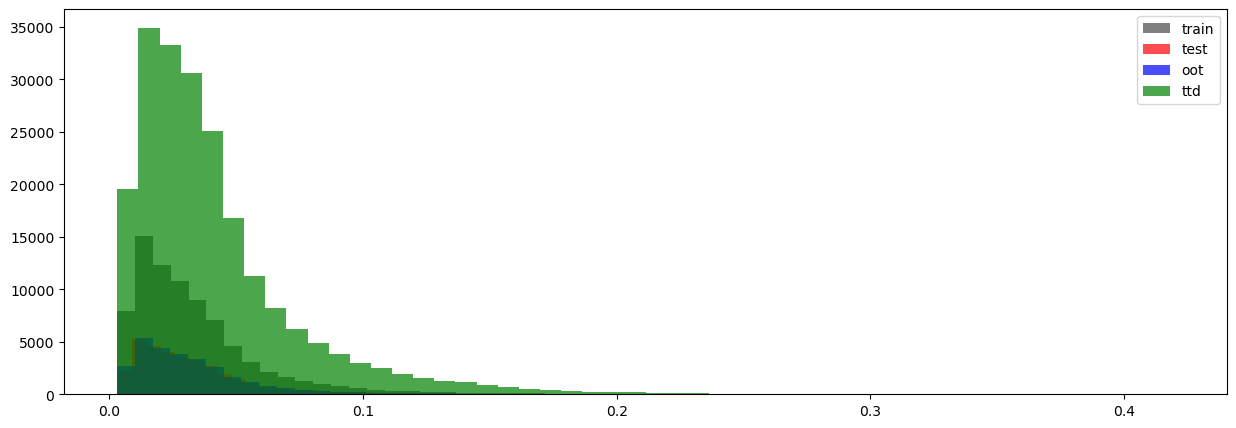

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize= (15, 5))
plt.hist(Train['p1'], bins= 50, label= 'train', color= 'black', alpha= 0.5)
plt.hist(Test['p1'], bins= 50, label= 'test', color= 'red', alpha= 0.7)
plt.hist(Oot['p1'], bins= 50, label= 'oot', color= 'blue', alpha= 0.7)
plt.hist(TTD['p1'], bins= 50, label= 'ttd', color= 'green', alpha= 0.7)
plt.legend()
plt.show()

In [99]:
Train['p1'].value_counts(dropna= False).head()

p1
0.042339    39
0.035788    38
0.028451    35
0.025407    28
0.026003    27
Name: count, dtype: int64

In [100]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     76782
[1]      2250
[2]       432
[-1]       68
Name: count, dtype: int64
bankruptcystatus
[0]     32892
[1]       983
[2]       183
[-1]       28
Name: count, dtype: int64


In [101]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [102]:
df_bv= pd.DataFrame()

for col in col_list:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_P1', 'Train_Count']
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_P1', 'Test_Count']
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

inquiryshortterm12month
inquiryauto12month
inquirynonshortterm12month
assetpropevercount
assetownership
inquirytelcom12month
addrinputtaxmarketvalue
addrlastmoveecontrajectory
criminalnonfelonycount
sourcenonderogcount03month
addrinputavmvalue
addrinputcountyratio
derogcount
criminalfelonycount
assetpropcurrentcount
addrcurrentlengthofres
educationprogramattended
addrinputtimeoldest
addrinputproblems
addrchangecount06month
addrprevioustimeoldest
addrlastmovetaxratiodiff
addrcurrenttaxmarketvalue
lienjudgmenttaxcount
educationinstitutionrating
lienjudgmentcourtcount
lienjudgmentcount
addrinputavmratio60monthprior
assetpropnewestmortgagetype
businesstitleleadership
addrchangecount24month
inquirycollections12month
evictiontimenewest
proflictypecategory
sourcenonderogcount
assetpropsalepurchaseratio
addrcurrentblockratio
subjectrecordtimenewest
addrchangecount12month
addrchangecount03month
assetpropsoldcount12month
addrcurrentdeedmailing
bankruptcychapter
assetpersonal
addrcurrenttractrati

In [103]:
pd.options.display.max_rows= 1000
df_bv

,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,inquiryshortterm12month,[0],2297.0,0.030359,0.031128,75661,986.0,0.030462,0.031083,32368.0,Yes
1,inquiryshortterm12month,[1],363.0,0.093774,0.090711,3871,154.0,0.089639,0.088731,1718.0,Yes
2,inquiryauto12month,[0],2041.0,0.028778,0.029565,70923,863.0,0.028336,0.029688,30456.0,Yes
3,inquiryauto12month,[1],619.0,0.071901,0.070790,8609,277.0,0.076309,0.070066,3630.0,Yes
4,inquirynonshortterm12month,[0],1529.0,0.026198,0.026598,58363,643.0,0.025682,0.026786,25037.0,Yes
5,inquirynonshortterm12month,[1],1131.0,0.053427,0.054513,21169,497.0,0.054923,0.053917,9049.0,Yes
6,assetpropevercount,"[-inf, 1.0)",1940.0,0.046945,0.047139,41325,843.0,0.047606,0.046835,17708.0,Yes
7,assetpropevercount,"[1.0, 2.0)",502.0,0.021773,0.022788,23056,193.0,0.019656,0.023053,9819.0,Yes
8,assetpropevercount,"[2.0, inf)",218.0,0.014388,0.015371,15151,104.0,0.015856,0.015674,6559.0,Yes
9,assetownership,[0],2016.0,0.046368,0.046767,43478,872.0,0.046786,0.046498,18638.0,Yes


In [105]:
for client in Train['client'].unique():
    print(client)
    get_risk_rank(model= xgbm_ln_v2_hpt_best_1, 
                  data= Train[Train['client']== client], 
                  data_h2o= train_h2o[train_h2o['client']== client], 
                  target= 'bad_flag', 
                  cols_tuple= col_tuple_pass, 
                  score_col= 'p1', 
                  weight= 'conwt')
    

Guardian
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
12326 405.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.061400,0.307528,0.095897,2466,2269.0,197.0,7.99,20.01,19.03,48.64,29.61
1,0.038734,0.061396,0.048568,2465,2356.0,109.0,4.42,40.00,38.80,75.56,36.76
2,0.025826,0.038727,0.031934,2465,2403.0,62.0,2.52,60.00,58.95,90.86,31.91
3,0.015219,0.025824,0.020353,2465,2442.0,23.0,0.93,80.00,79.44,96.54,17.10
4,0.003325,0.015212,0.010503,2465,2451.0,14.0,0.57,100.00,100.00,100.00,0.00


{'Gini': 46.150000000000006, 'KS': 36.76}
Numerica
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
16451 773.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.052920,0.353512,0.080805,3291,2931.0,360.0,10.94,20.0,18.69,46.57,27.88
1,0.039164,0.052913,0.045022,3290,3118.0,172.0,5.23,40.0,38.58,68.82,30.24
2,0.029358,0.039161,0.034312,3290,3153.0,137.0,4.16,60.0,58.69,86.55,27.86
3,0.018441,0.029356,0.024032,3290,3214.0,76.0,2.31,80.0,79.19,96.38,17.19
4,0.003411,0.018441,0.012760,3290,3262.0,28.0,0.85,100.0,100.00,100.00,0.00


{'Gini': 41.27, 'KS': 30.24}
CPM
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
13409 326.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.046580,0.298377,0.080543,2682,2543.0,139.0,5.18,20.00,19.44,42.64,23.20
1,0.029146,0.046578,0.036851,2682,2605.0,77.0,2.87,40.00,39.35,66.26,26.91
2,0.019708,0.029139,0.024122,2682,2620.0,62.0,2.31,60.00,59.37,85.28,25.91
3,0.012751,0.019703,0.016080,2682,2646.0,36.0,1.34,80.01,79.60,96.32,16.72
4,0.003357,0.012749,0.009604,2681,2669.0,12.0,0.45,100.00,100.00,100.00,0.00


{'Gini': 37.1, 'KS': 26.91}
Arkansas
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
5903 165.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.041633,0.354161,0.071976,1181,1082.0,99.0,8.38,20.01,18.86,60.00,41.14
1,0.025526,0.041608,0.032455,1181,1148.0,33.0,2.79,40.01,38.86,80.00,41.14
2,0.016696,0.025521,0.020606,1180,1158.0,22.0,1.86,60.00,59.04,93.33,34.29
3,0.010991,0.016692,0.013779,1181,1172.0,9.0,0.76,80.01,79.47,98.79,19.32
4,0.003686,0.010991,0.008486,1180,1178.0,2.0,0.17,100.00,100.00,100.00,0.00


{'Gini': 54.36, 'KS': 41.14}
Tower
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
11287 391.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.038886,0.270454,0.058834,2258,2083.0,175.0,7.75,20.01,19.12,44.76,25.64
1,0.026839,0.038874,0.032466,2257,2168.0,89.0,3.94,40.00,39.01,67.52,28.51
2,0.018038,0.026830,0.022370,2258,2198.0,60.0,2.66,60.01,59.19,82.86,23.67
3,0.011822,0.018019,0.014718,2257,2216.0,41.0,1.82,80.00,79.52,93.35,13.83
4,0.003156,0.011821,0.008925,2257,2231.0,26.0,1.15,100.00,100.00,100.00,0.00


{'Gini': 36.66, 'KS': 28.51}
GESA
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
5161 135.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.046177,0.265522,0.069727,1033,967.0,66.0,6.39,20.02,19.24,48.89,29.65
1,0.033204,0.046164,0.039468,1032,1002.0,30.0,2.91,40.01,39.18,71.11,31.93
2,0.021377,0.033204,0.027191,1032,1009.0,23.0,2.23,60.01,59.25,88.15,28.90
3,0.012508,0.021368,0.016595,1032,1023.0,9.0,0.87,80.00,79.61,94.81,15.20
4,0.003616,0.012498,0.009268,1032,1025.0,7.0,0.68,100.00,100.00,100.00,0.00


{'Gini': 42.27, 'KS': 31.93}
HFCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
1463 41.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.044310,0.170557,0.066698,293,278.0,15.0,5.12,20.03,19.55,36.59,17.04
1,0.030081,0.044272,0.036259,293,276.0,17.0,5.80,40.05,38.96,78.05,39.09
2,0.020796,0.030014,0.025258,292,285.0,7.0,2.40,60.01,59.00,95.12,36.12
3,0.013154,0.020792,0.016841,293,291.0,2.0,0.68,80.04,79.47,100.00,20.53
4,0.003976,0.013123,0.009832,292,292.0,0.0,0.00,100.00,100.00,100.00,0.00


{'Gini': 45.11, 'KS': 39.09}
Hawaii
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
3952 43.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.038921,0.166218,0.054782,791,767.0,24.0,3.03,20.02,19.62,55.81,36.19
1,0.029669,0.038917,0.033986,790,778.0,12.0,1.52,40.01,39.52,83.72,44.20
2,0.022124,0.029654,0.025927,791,788.0,3.0,0.38,60.02,59.68,90.70,31.02
3,0.015061,0.022120,0.018847,790,788.0,2.0,0.25,80.01,79.84,95.35,15.51
4,0.003574,0.015058,0.010846,790,788.0,2.0,0.25,100.00,100.00,100.00,0.00


{'Gini': 50.77, 'KS': 44.2}
Bethpage
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
9580 381.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.041599,0.217260,0.061811,1917,1759.0,158.0,8.24,20.01,19.12,41.47,22.35
1,0.029593,0.041598,0.035062,1915,1822.0,93.0,4.86,40.00,38.93,65.88,26.95
2,0.021403,0.029590,0.025384,1917,1849.0,68.0,3.55,60.01,59.03,83.73,24.70
3,0.014019,0.021401,0.017653,1916,1876.0,40.0,2.09,80.01,79.42,94.23,14.81
4,0.004040,0.014017,0.010373,1915,1893.0,22.0,1.15,100.00,100.00,100.00,0.00


{'Gini': 35.53, 'KS': 26.95}


### Basic Checks

In [106]:
TTD['funded_flag'].sum(), Train['funded_flag'].sum(), Test['funded_flag'].sum()

(94522.0, 79532.0, 34086.0)

In [107]:
TTD['id']= TTD['unique_id']+TTD['client']
Train['id']= Train['unique_id']+Train['client']
Test['id']= Test['unique_id']+Test['client']
Oot['id']= Oot['unique_id']+Oot['client']

In [108]:
Train[(Train['id'].isin(TTD['id'].unique())) & (Train['client']!= 'CPM')].shape, Train[Train['client']!='CPM'].shape

((66123, 147), (66123, 147))

In [109]:
Test[(Test['id'].isin(TTD['id'].unique())) & (Test['client']!= 'CPM')].shape, Test[Test['client']!='CPM'].shape

((28399, 147), (28399, 147))

In [110]:
Train[(Train['id'].isin(Test['id'].unique()))].shape

(0, 147)

In [111]:
TTD[TTD['id'].isin(Train[Train['client']!= 'CPM']['id'].unique())]['p1'].describe(), Train[Train['client']!= 'CPM']['p1'].describe()

(count    66123.000000
 mean         0.034147
 std          0.026683
 min          0.003156
 25%          0.015957
 50%          0.027697
 75%          0.042794
 max          0.354161
 Name: p1, dtype: float64,
 count    66123.000000
 mean         0.034147
 std          0.026683
 min          0.003156
 25%          0.015957
 50%          0.027697
 75%          0.042794
 max          0.354161
 Name: p1, dtype: float64)

In [112]:
Train['client'].value_counts(dropna= False)

client
Numerica    16451
CPM         13409
Guardian    12326
Tower       11287
Bethpage     9580
Arkansas     5903
GESA         5161
Hawaii       3952
HFCU         1463
Name: count, dtype: int64

In [113]:
import datetime
Train[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Train_{product}_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
Test[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Test_{product}_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
Oot[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Oot_{product}_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
TTD[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_TTD_{product}_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)